In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import statsmodels.api as sm
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error 
from MiniProject_Library import *


import warnings
warnings.filterwarnings('ignore')
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from pylab import rcParams
rcParams['figure.figsize']=12,7
plt.rcParams['figure.dpi'] = 140

In [3]:
df=pd.read_excel('DS3_C6_S4_TimeSeries_Sales_Data_Project.xls',index_col='Order Date' , parse_dates=True)
df.head(5)

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,,,
2016-11-08,1,CA-2016-152156,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
2016-11-08,2,CA-2016-152156,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2016-06-12,3,CA-2016-138688,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
2015-10-11,4,US-2015-108966,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
2015-10-11,5,US-2015-108966,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


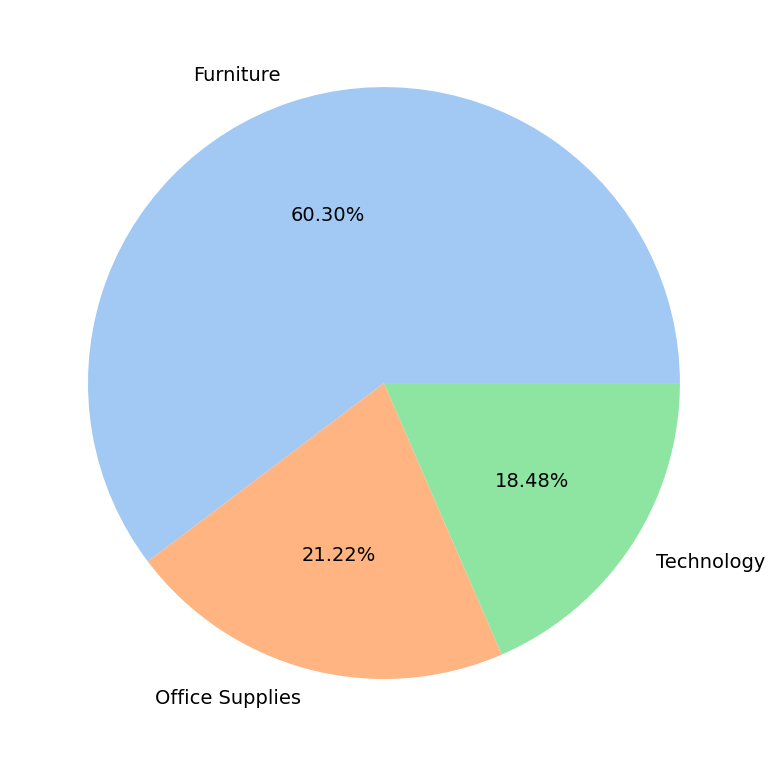

In [4]:
colors = sns.color_palette('pastel')[0:10]
plt.pie(df['Category'].value_counts(),autopct='%.2f%%',labels=df.Category.unique(),colors=colors);


In [5]:
df.Category.unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [6]:
furn=df[['Sales','Profit','Category']][df.Category=='Furniture'].sort_index()


In [7]:
os=df[['Sales','Profit','Category']][df.Category=='Office Supplies'].sort_index()

In [8]:
tech=df[['Sales','Profit','Category']][df.Category=='Technology'].sort_index()

<AxesSubplot:xlabel='Order Date'>

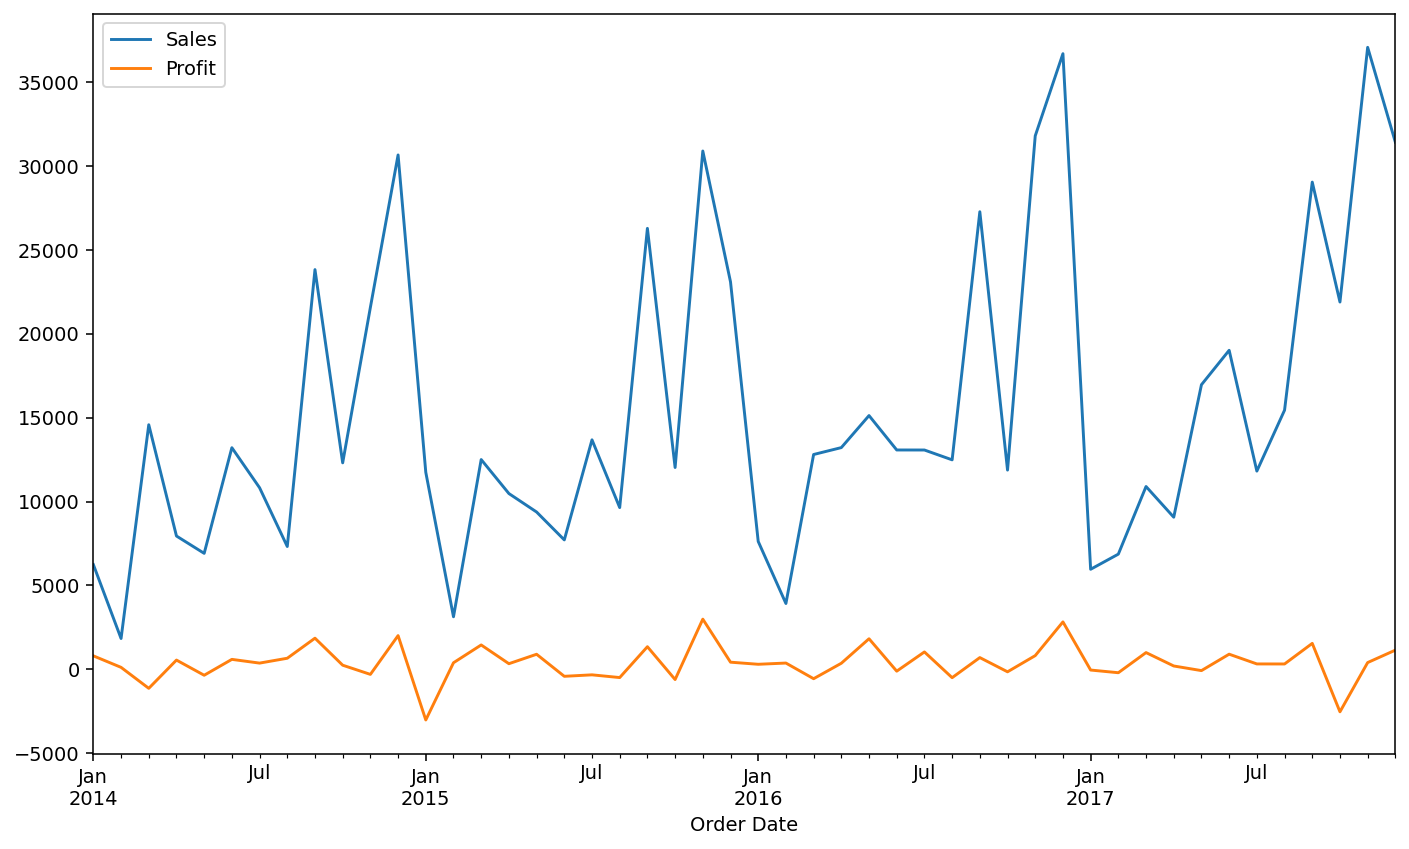

In [9]:
furn.resample('M').sum().Sales.plot(legend='Sales')
furn.resample('M').sum().Profit.plot(legend='Profit')

<AxesSubplot:xlabel='Order Date'>

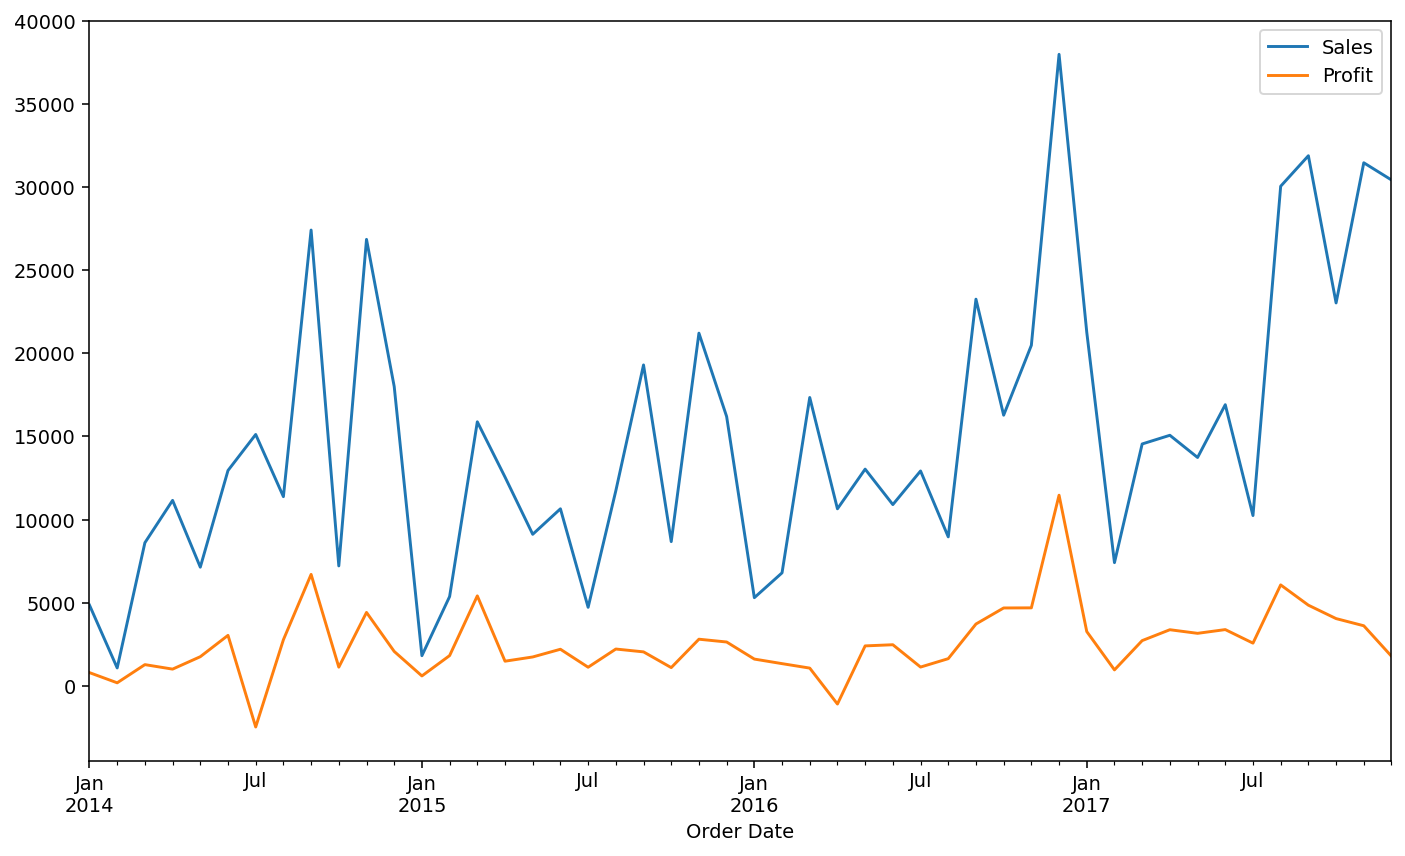

In [10]:
os.resample('M').sum().Sales.plot(legend='Sales')
os.resample('M').sum().Profit.plot(legend='Profit')

<AxesSubplot:xlabel='Order Date'>

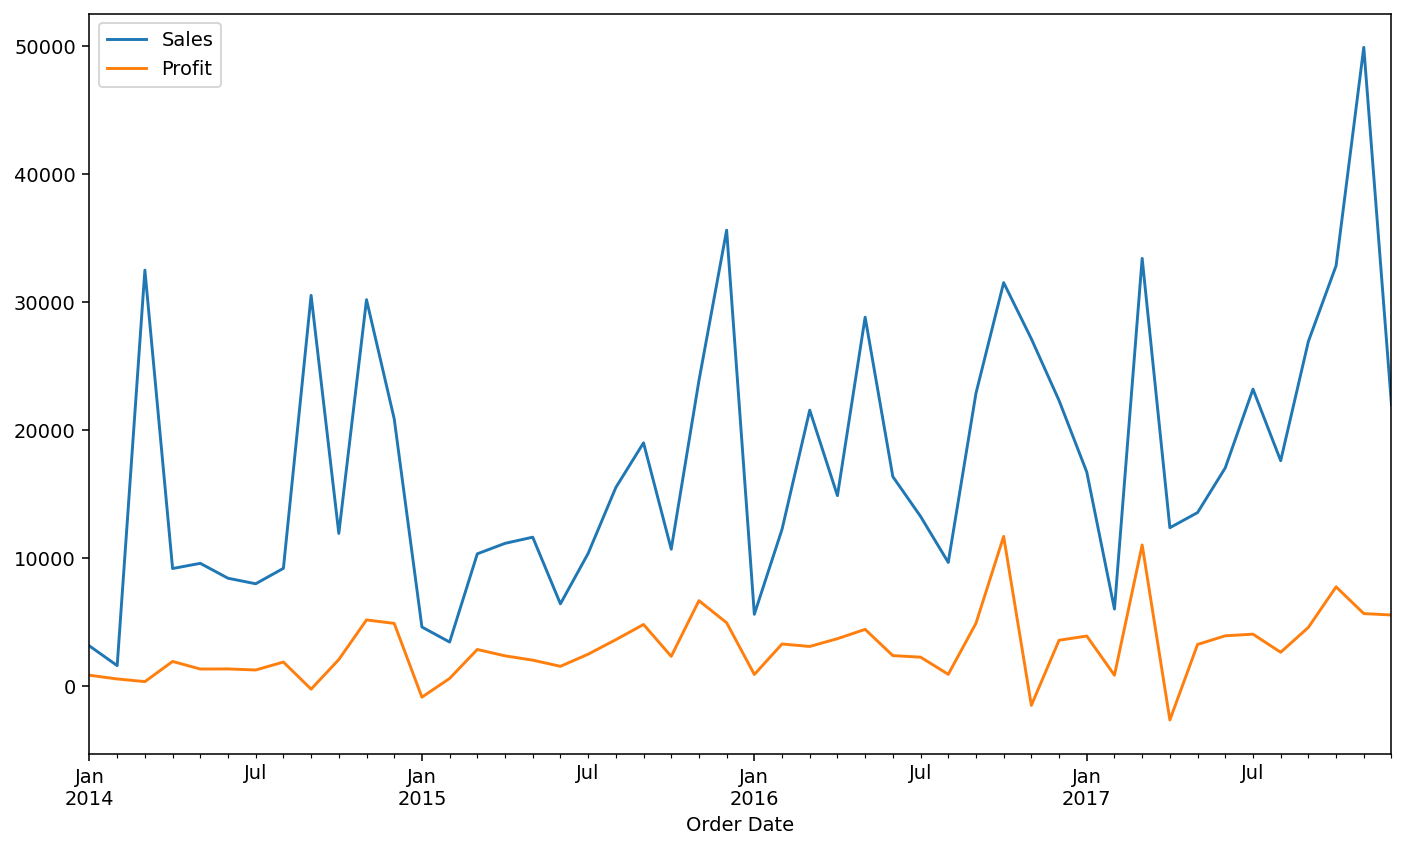

In [11]:
tech.resample('M').sum().Sales.plot(legend='Sales')
tech.resample('M').sum().Profit.plot(legend='Profit')

In [12]:
def checkstat(data):
    movingAverage = data.rolling(window=12).mean()
    movingSTD = data.rolling(window=12).std()
    #Plot rolling statistics: 
    orig =plt.plot(data, color='blue',label='Original') 
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean') 
    std =plt.plot(movingSTD, color='black', label = 'Rolling Std')
    plt. legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    pvalue=adfuller(data)[1]
    if pvalue<.05:
        msg =  "pvalue={}. Data is Stationary. Proceed to model building".format(pvalue)
    else:
        msg = "pvalue={}. Data is not Stationary. Make the data stationary before model building".format(pvalue)
    return msg

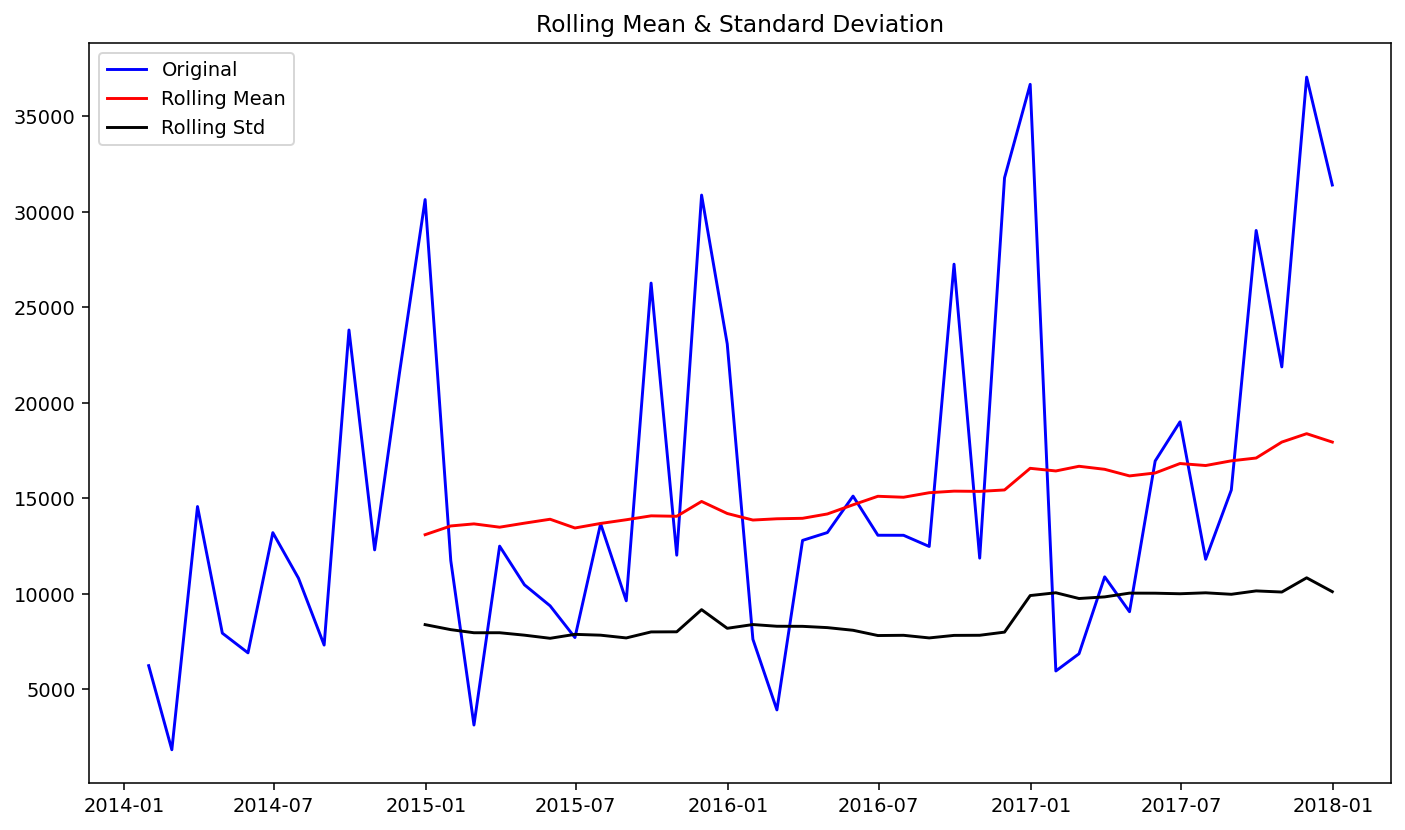

'pvalue=8.450793985809654e-05. Data is Stationary. Proceed to model building'

In [13]:
checkstat(furn.resample('M').sum().Sales)

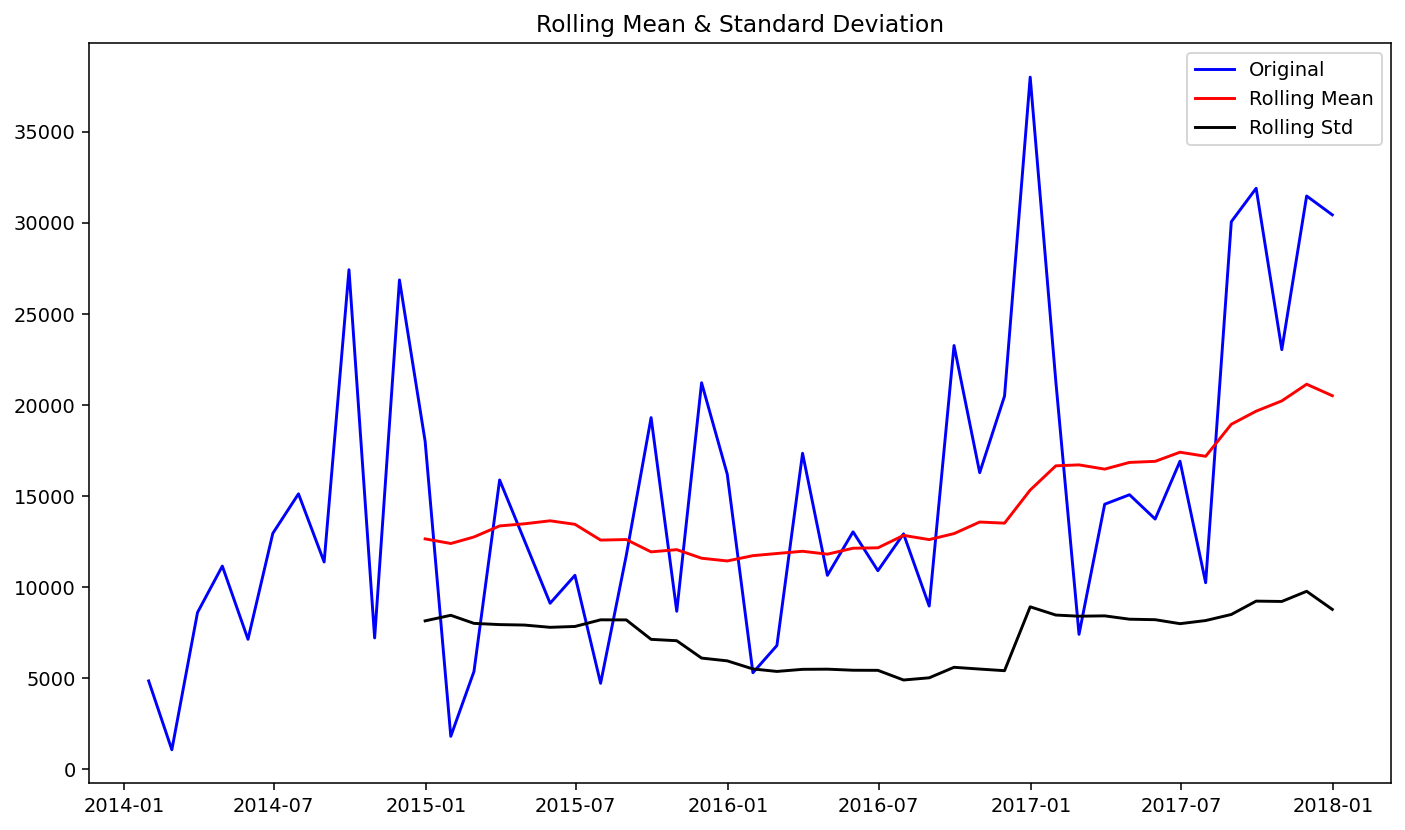

'pvalue=0.329487275494728. Data is not Stationary. Make the data stationary before model building'

In [14]:
checkstat(os.resample('M').sum().Sales)

In [15]:
df_os = os.resample('M').sum().Sales - os.resample('M').sum().Sales.shift(1)
df_os.dropna(inplace=True)

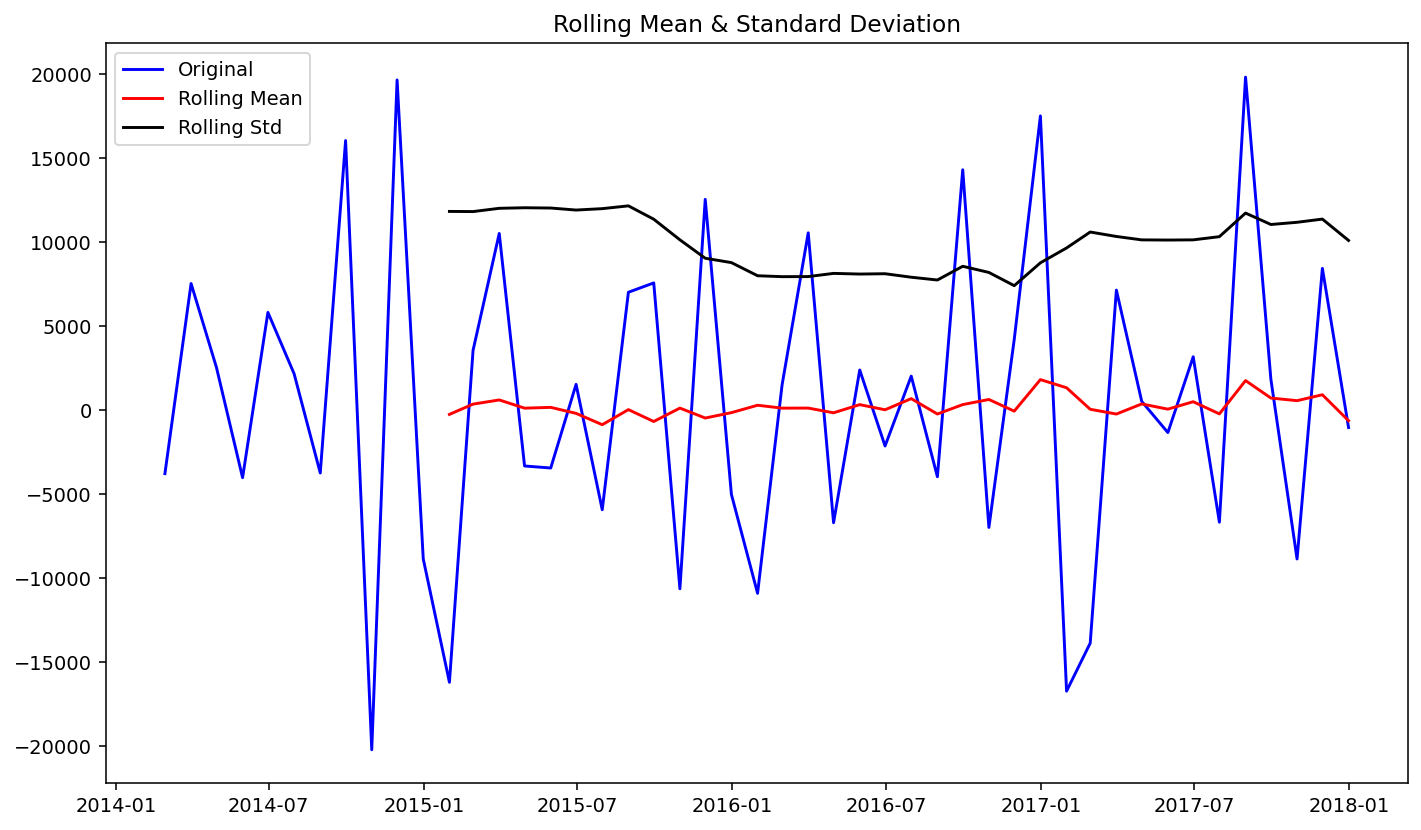

'pvalue=0.0004287262459097745. Data is Stationary. Proceed to model building'

In [16]:
checkstat(df_os)

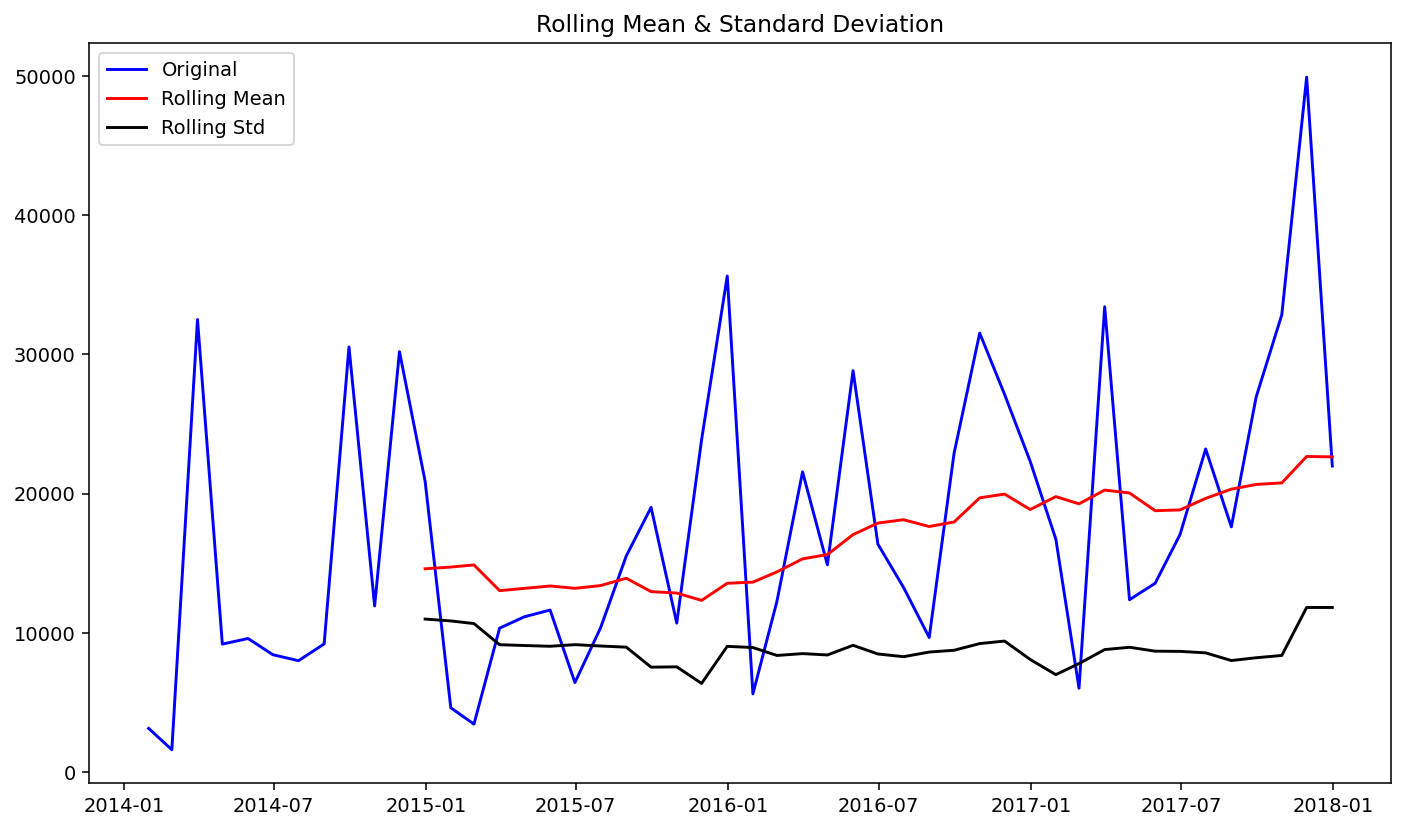

'pvalue=1.861596730206398e-06. Data is Stationary. Proceed to model building'

In [17]:
checkstat(tech.resample('M').sum().Sales)

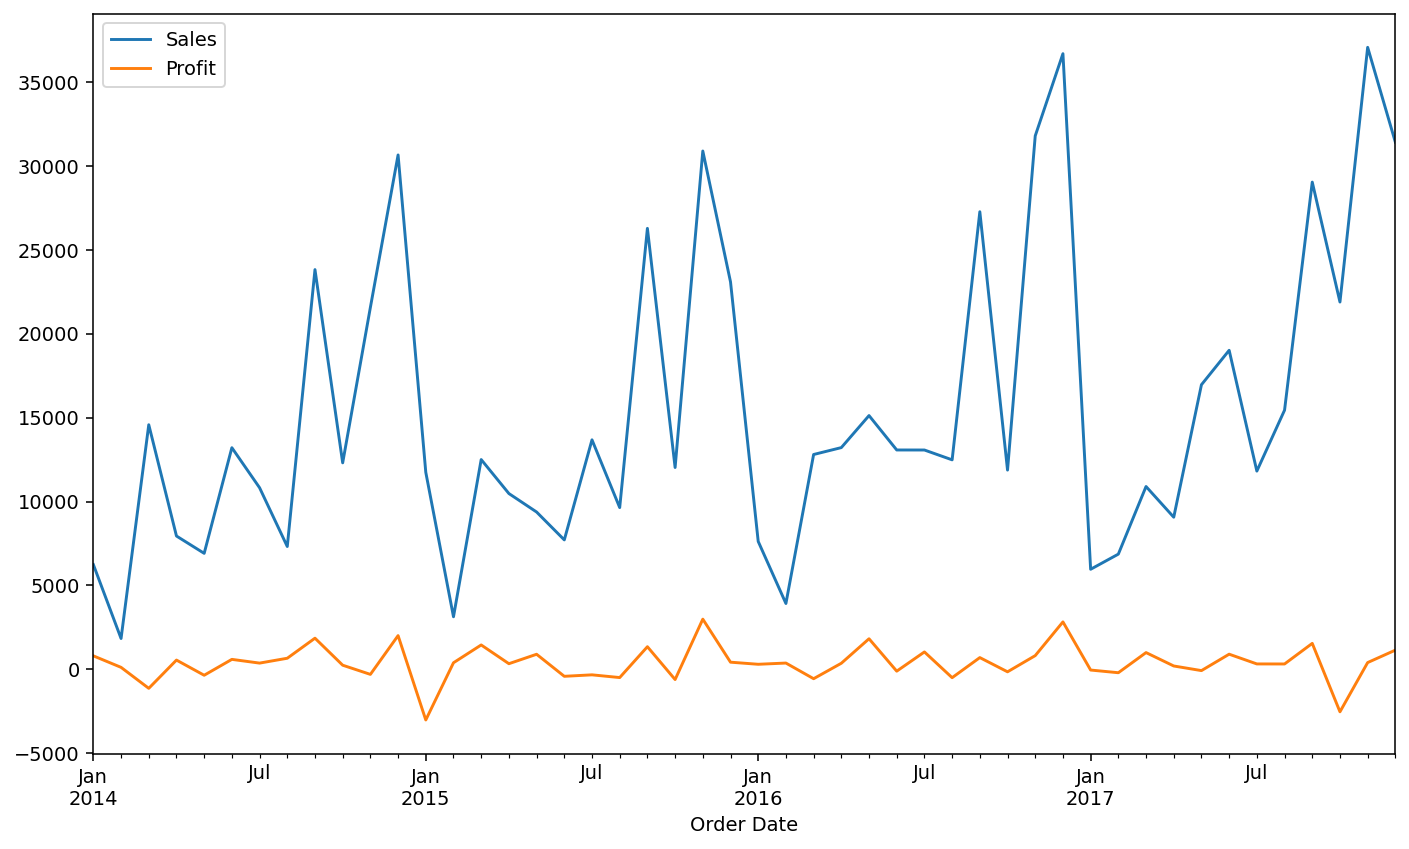

In [18]:
furn.resample('M').sum().plot();


### Decomposition Furniture

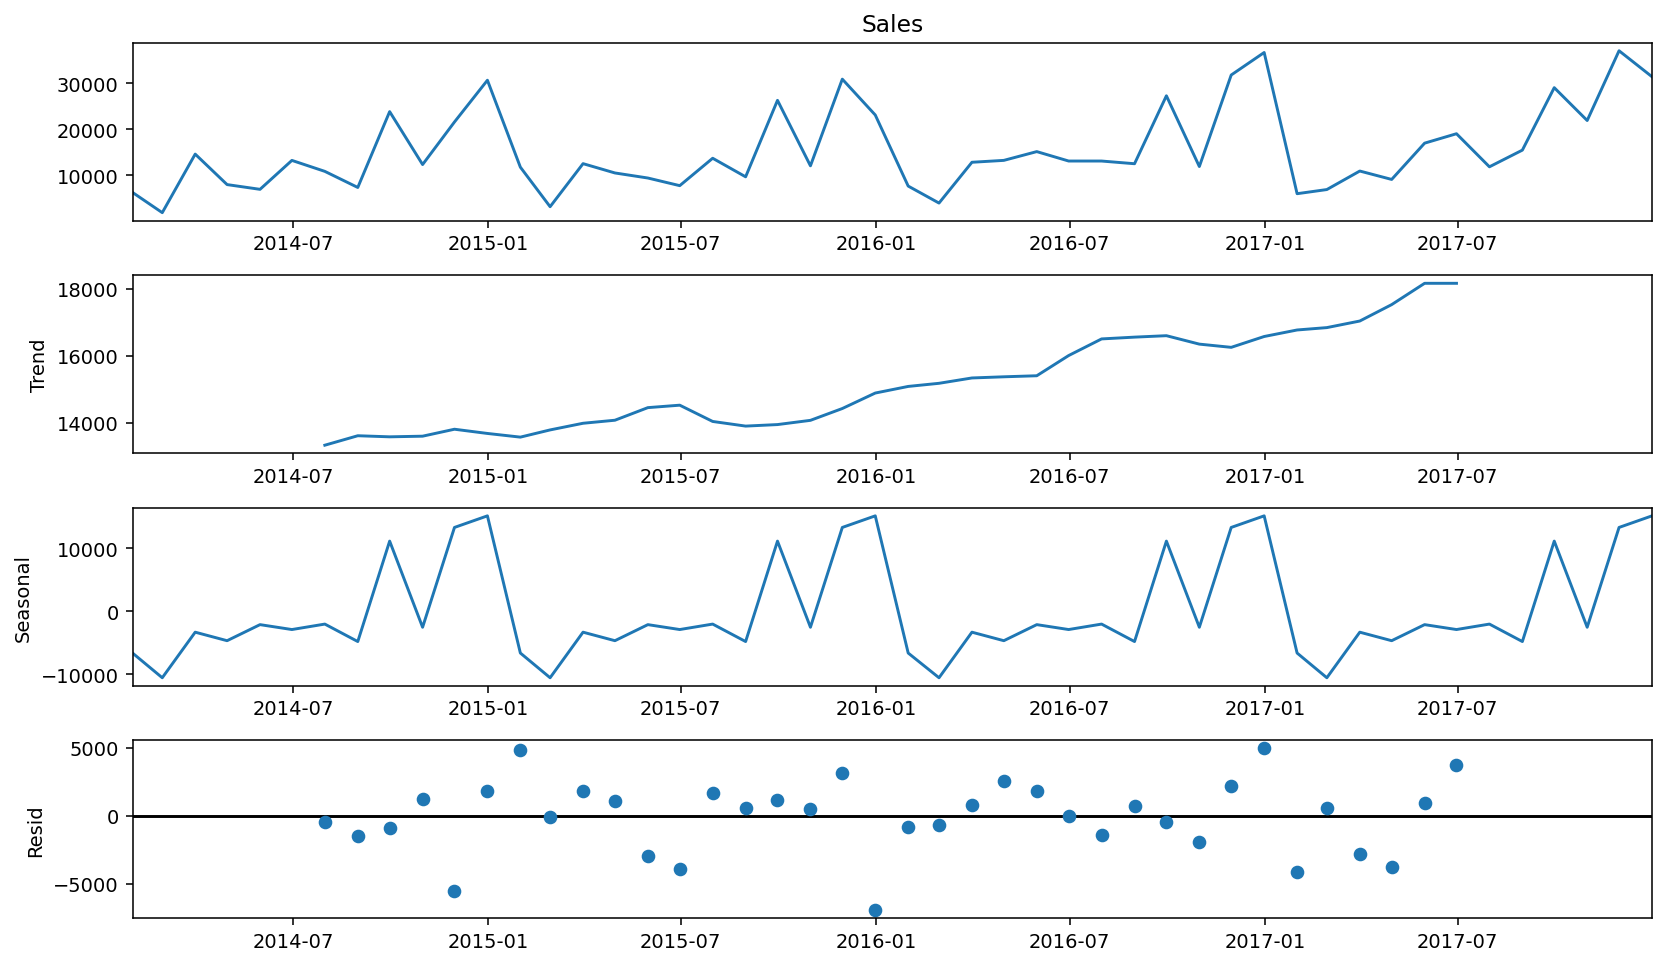

In [19]:
seasonal_decompose(furn.resample('M').sum().Sales,period=12).plot();

### Decomposition Office supply

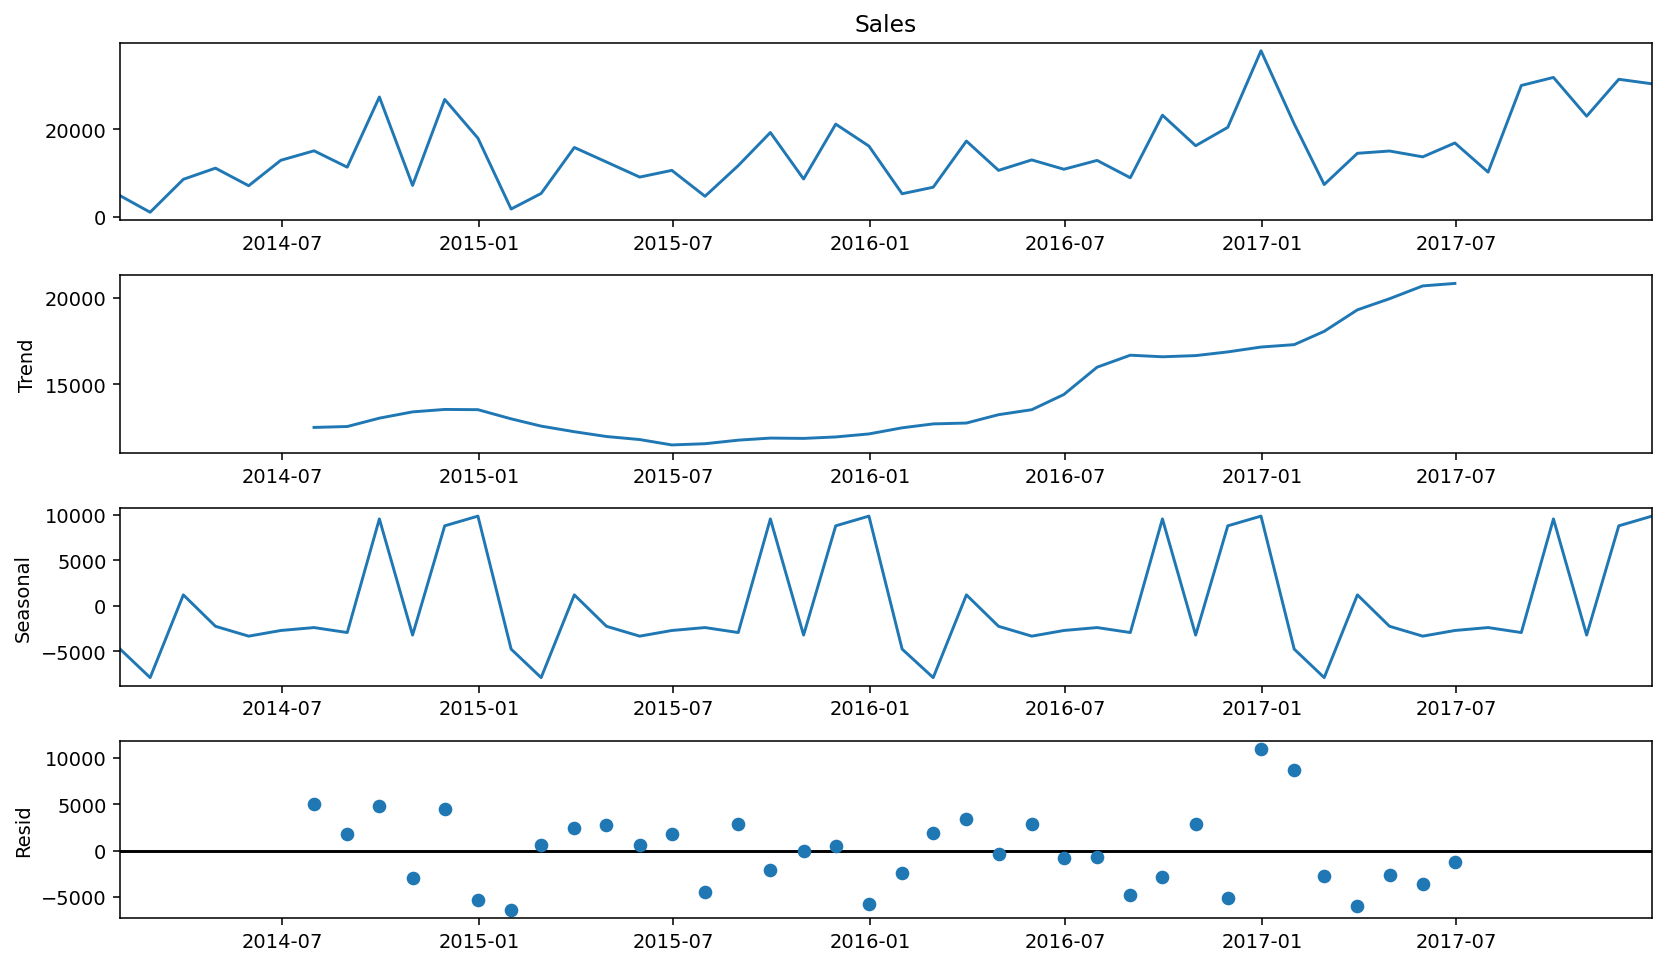

In [20]:
seasonal_decompose(os.resample('M').sum().Sales,period=12).plot();

### Decomposition Technology

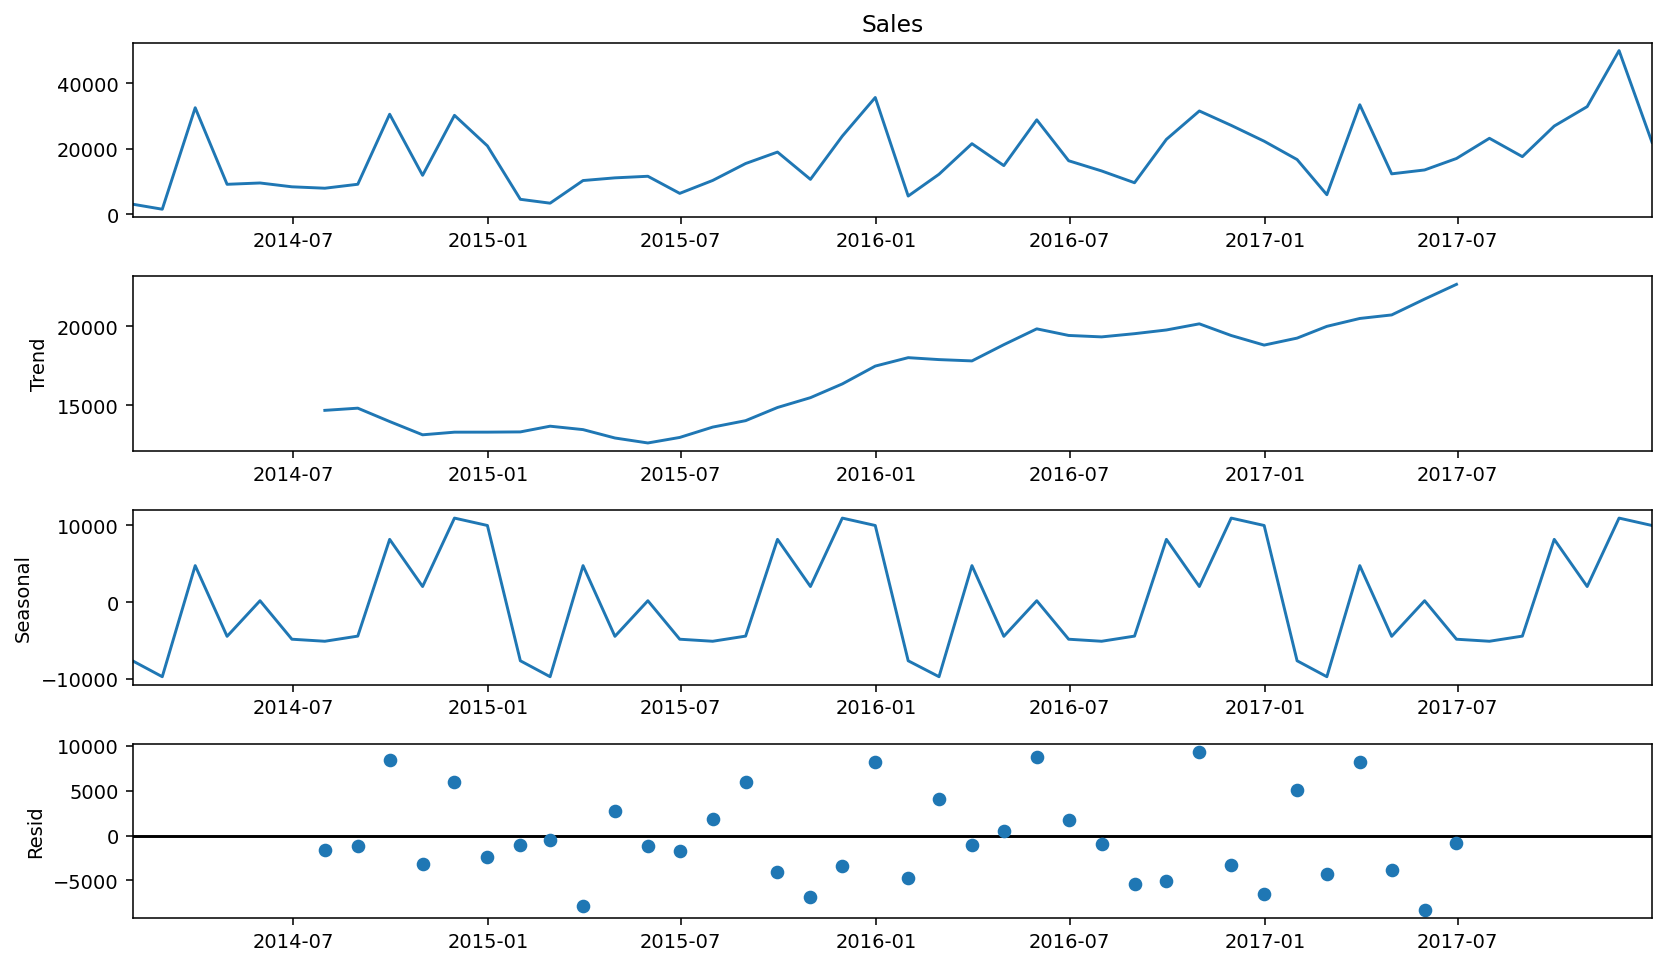

In [21]:
seasonal_decompose(tech.resample('M').sum().Sales,period=12).plot();

### ACF and PACF in Furniture

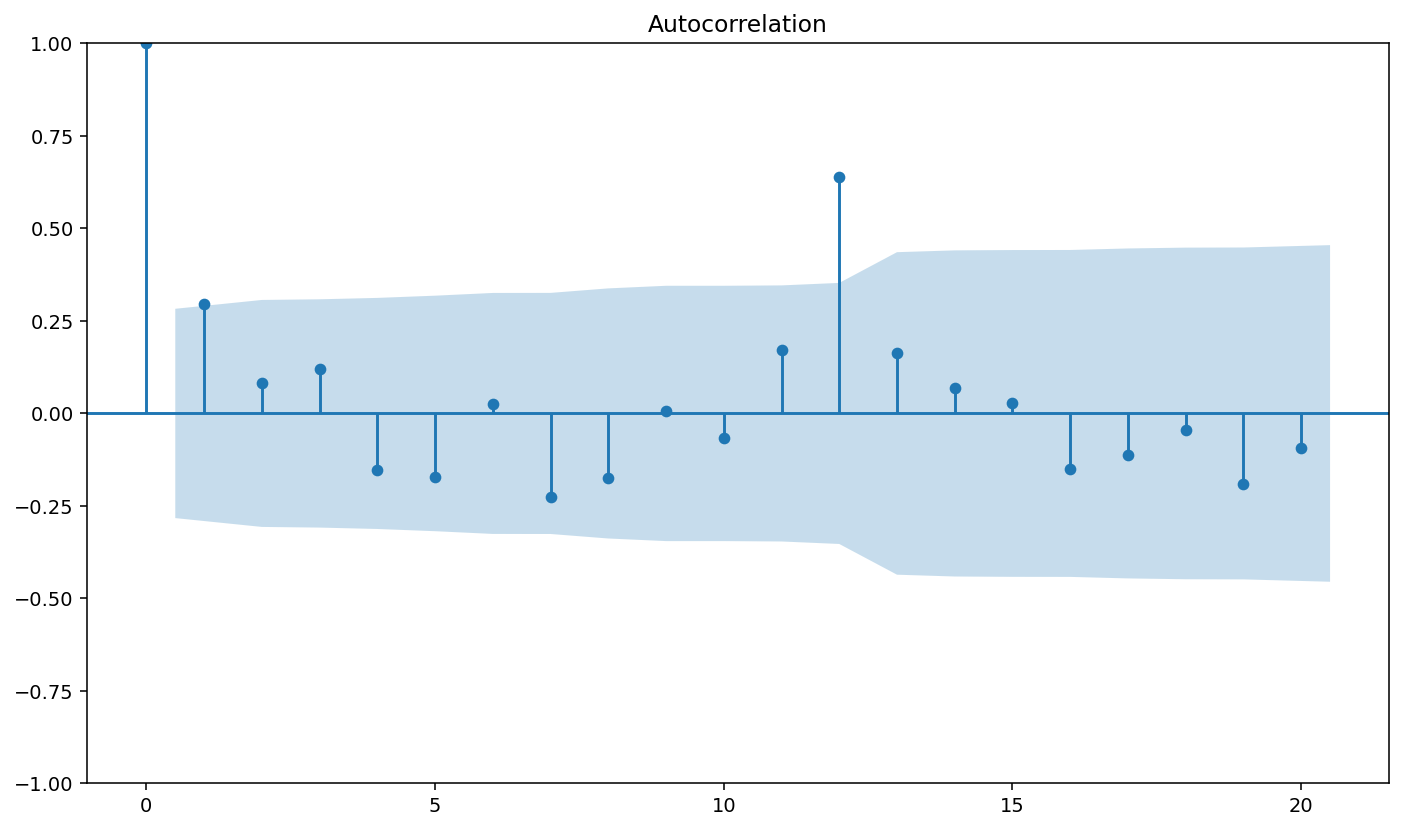

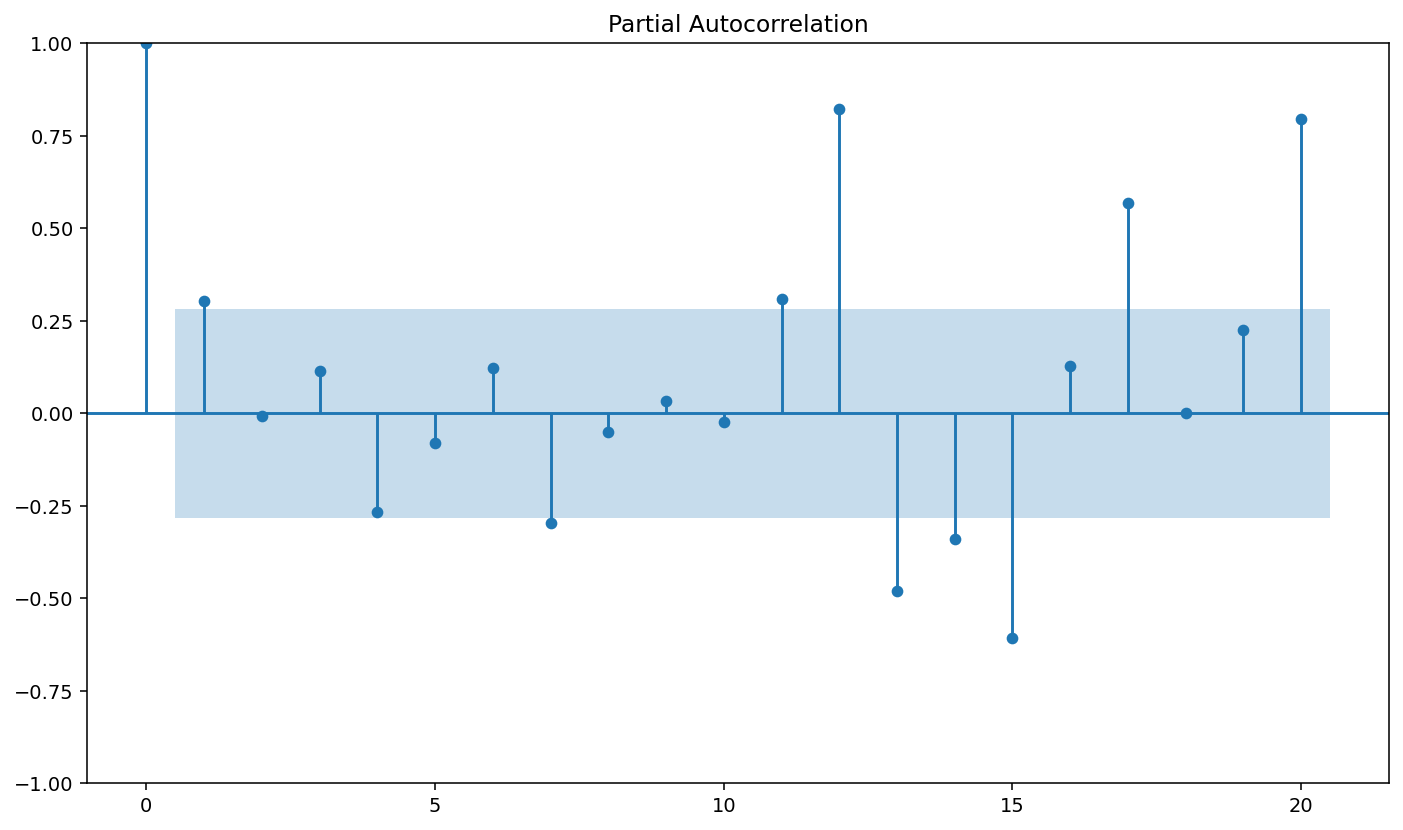

In [22]:
plot_acf(furn.resample('M').sum().Sales,lags=20);
plot_pacf(furn.resample('M').sum().Sales,lags=20);

In [23]:
for i in range(1,10,2):
  for j in range(7,10):
    ar_model = ARIMA(furn.resample('M').sum().Sales,order=(j,0,i))
    ar_fit = ar_model.fit()
    print(f'When p is taken as = {j} and q is taken as = {i} , value of AIC is {ar_fit.aic}')

When p is taken as = 7 and q is taken as = 1 , value of AIC is 1016.8398390276209
When p is taken as = 8 and q is taken as = 1 , value of AIC is 1018.8094767493749
When p is taken as = 9 and q is taken as = 1 , value of AIC is 1020.7468016539774
When p is taken as = 7 and q is taken as = 3 , value of AIC is 1014.5184829867803
When p is taken as = 8 and q is taken as = 3 , value of AIC is 1015.639516925216
When p is taken as = 9 and q is taken as = 3 , value of AIC is 1017.8624605837351
When p is taken as = 7 and q is taken as = 5 , value of AIC is 1007.3935406794243
When p is taken as = 8 and q is taken as = 5 , value of AIC is 1010.2640680671088
When p is taken as = 9 and q is taken as = 5 , value of AIC is 1012.5495578028989
When p is taken as = 7 and q is taken as = 7 , value of AIC is 1010.3320523284774
When p is taken as = 8 and q is taken as = 7 , value of AIC is 1012.0684714131171
When p is taken as = 9 and q is taken as = 7 , value of AIC is 1013.1008679989536
When p is taken a

### ACF and PACF in Technology

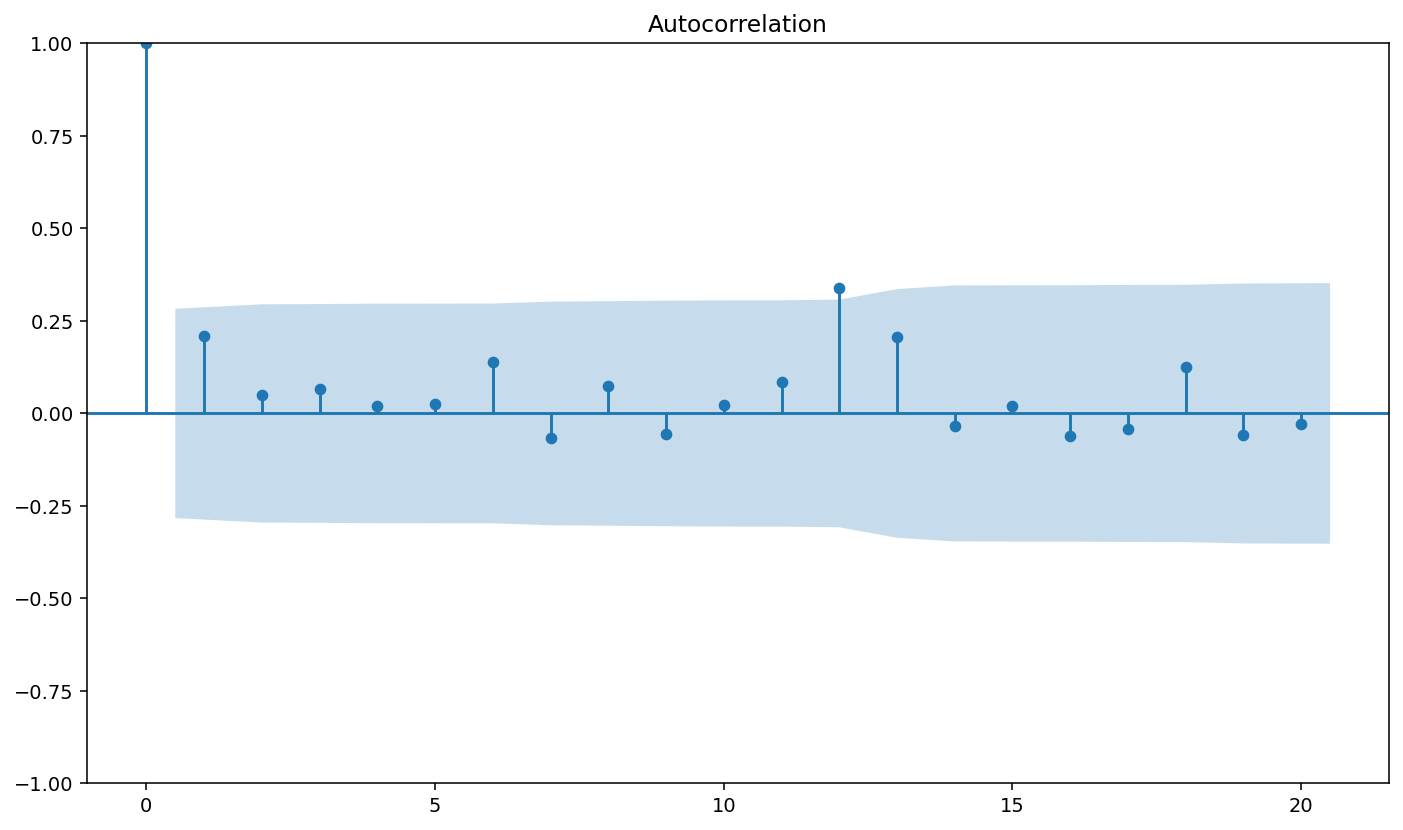

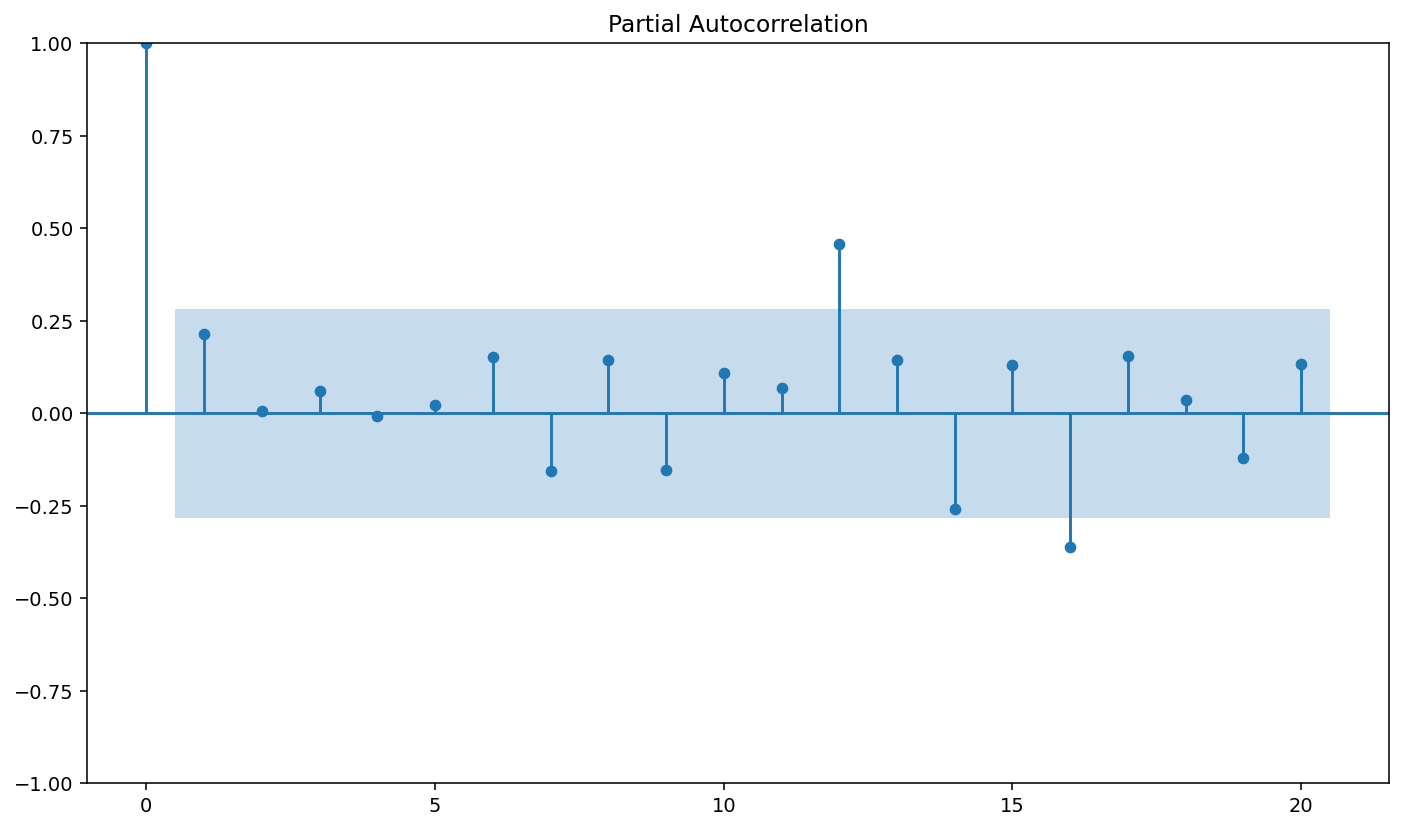

In [24]:
plot_acf(tech.resample('M').sum().Sales,lags=20);
plot_pacf(tech.resample('M').sum().Sales,lags=20);

In [25]:
for i in range(1,3):
  for j in range(1,10):
    ar_model = ARIMA(tech.resample('M').sum().Sales,order=(j,0,i))
    ar_fit = ar_model.fit()
    print(f'When p is taken as = {j} and q is taken as = {i} , value of AIC is {ar_fit.aic}')

When p is taken as = 1 and q is taken as = 1 , value of AIC is 1029.1161385812918
When p is taken as = 2 and q is taken as = 1 , value of AIC is 1030.653308355525
When p is taken as = 3 and q is taken as = 1 , value of AIC is 1032.5474187655827
When p is taken as = 4 and q is taken as = 1 , value of AIC is 1035.2230860178583
When p is taken as = 5 and q is taken as = 1 , value of AIC is 1036.2532587408987
When p is taken as = 6 and q is taken as = 1 , value of AIC is 1033.9408524911994
When p is taken as = 7 and q is taken as = 1 , value of AIC is 1035.8380368670137
When p is taken as = 8 and q is taken as = 1 , value of AIC is 1037.469697063134
When p is taken as = 9 and q is taken as = 1 , value of AIC is 1039.1146296124807
When p is taken as = 1 and q is taken as = 2 , value of AIC is 1030.4732995963116
When p is taken as = 2 and q is taken as = 2 , value of AIC is 1032.43665094078
When p is taken as = 3 and q is taken as = 2 , value of AIC is 1031.6257634158349
When p is taken as =

In [26]:
def forecasting(data,p,d,q):
    model = ARIMA(data.resample('M').sum().Sales,order=(p,d,q))
    model_fit = model.fit()
    fig,ax=plt.subplots(1,2,figsize=(22,7))
    pd.concat([data.resample('M').sum().Sales,model_fit.predict(start=47,end=73)]).plot(ax=ax[0],label='Actual')
    model_fit.predict(start=47,end=73).plot(ax=ax[0],label='prediction')
    ax[0].legend()
    
    print(model_fit.aic)
    pd.concat([data.resample('M').sum().Sales,model_fit.forecast(24)],axis=0).plot(label='Actual',ax=ax[1])
    model_fit.forecast(24).plot(label='forecasted')
    ax[1].legend()
    plt.suptitle(data.Category[0],size=25)

#
def forecasting_profit(data,p,q):
    model = ARIMA(data.resample('M').sum().Profit,order=(p,0,q))
    model_fit = model.fit()
    fig,ax=plt.subplots(1,2,figsize=(22,7))
    pd.concat([data.resample('M').sum().Profit,model_fit.predict(start=47,end=100)]).plot(ax=ax[0],label='Actual')
    model_fit.predict(start=47,end=100).plot(ax=ax[0],label='prediction')
    ax[0].legend()
    
    print(model_fit.aic)
    pd.concat([data.resample('M').sum().Profit,model_fit.forecast(50)],axis=0).plot(label='Actual',ax=ax[1])
    model_fit.forecast(50).plot(label='forecasted')
    ax[1].legend()
    plt.suptitle(data.Category[0],size=25)

### ARMA Furniture

1005.2358304621048


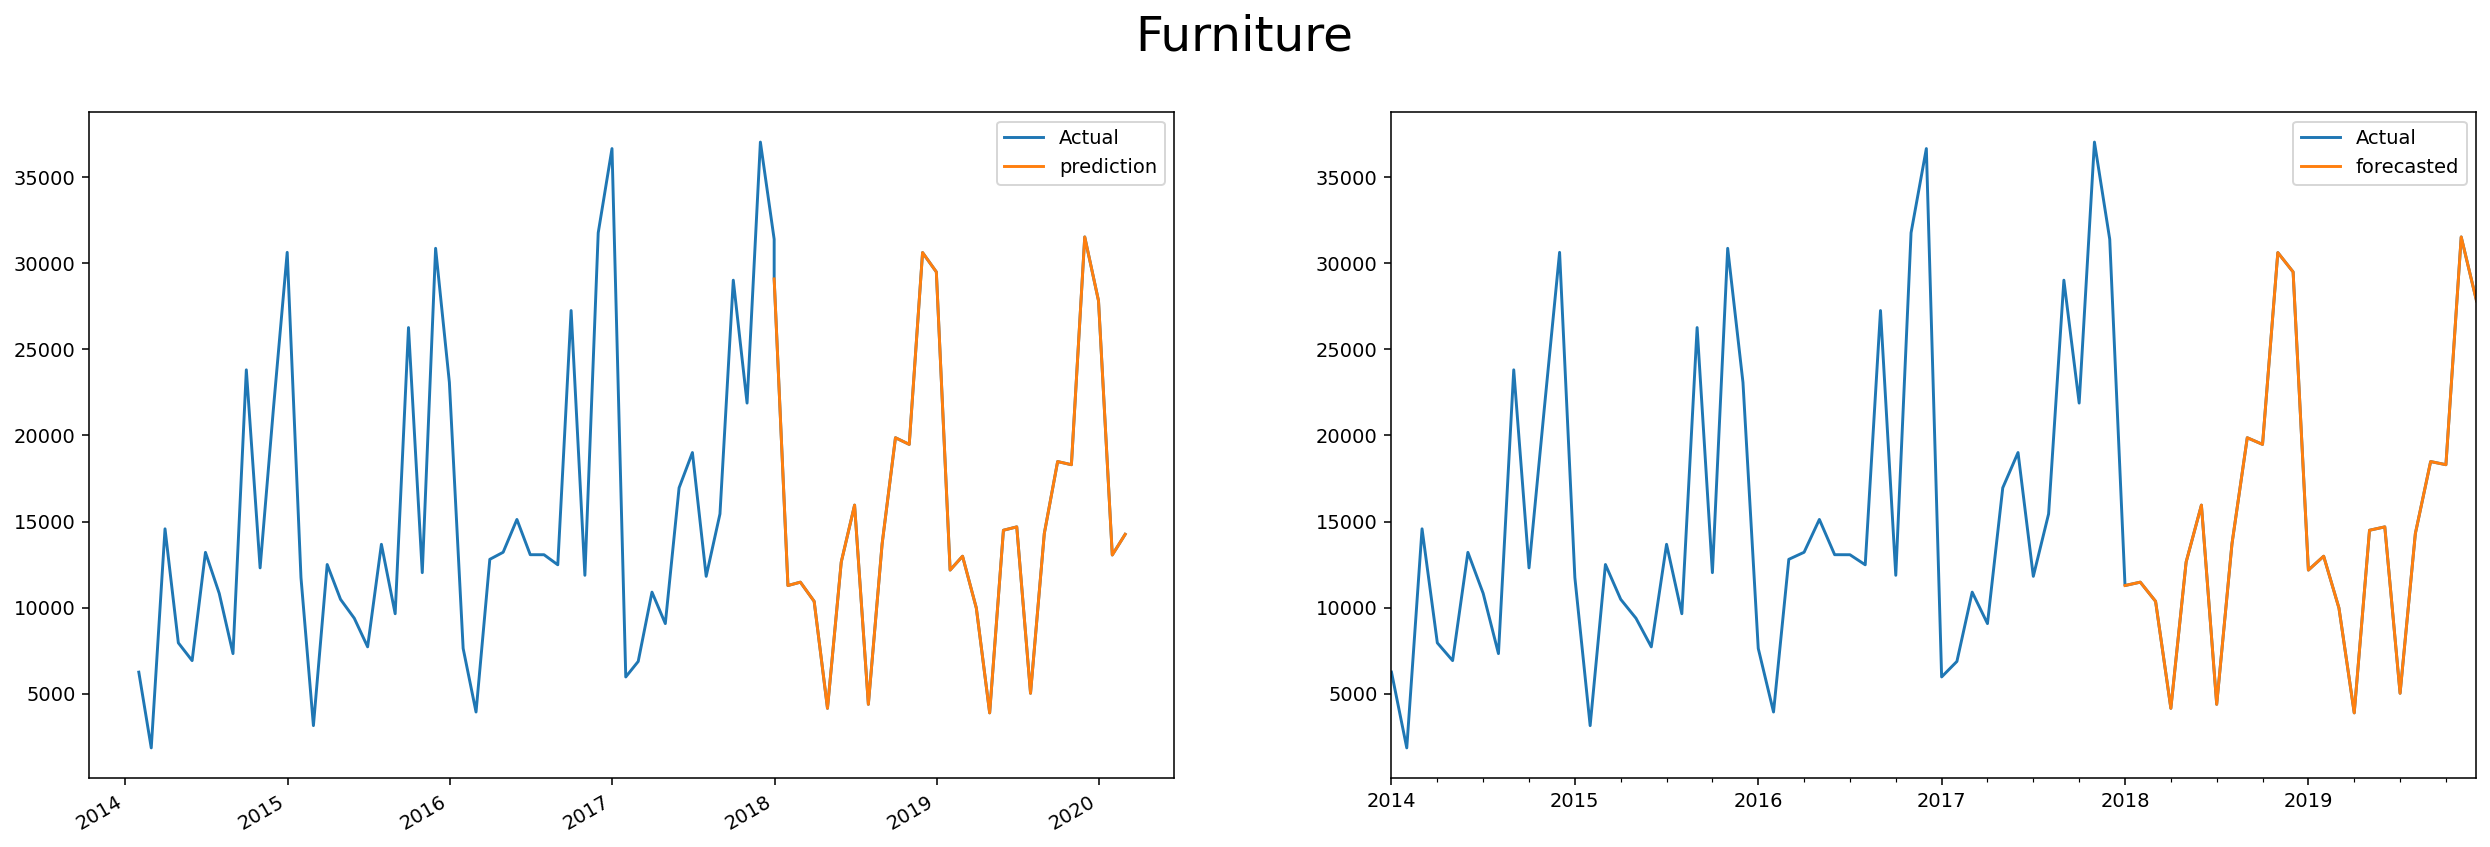

In [27]:
forecasting(furn,8,0,9)

1046.6808325175325


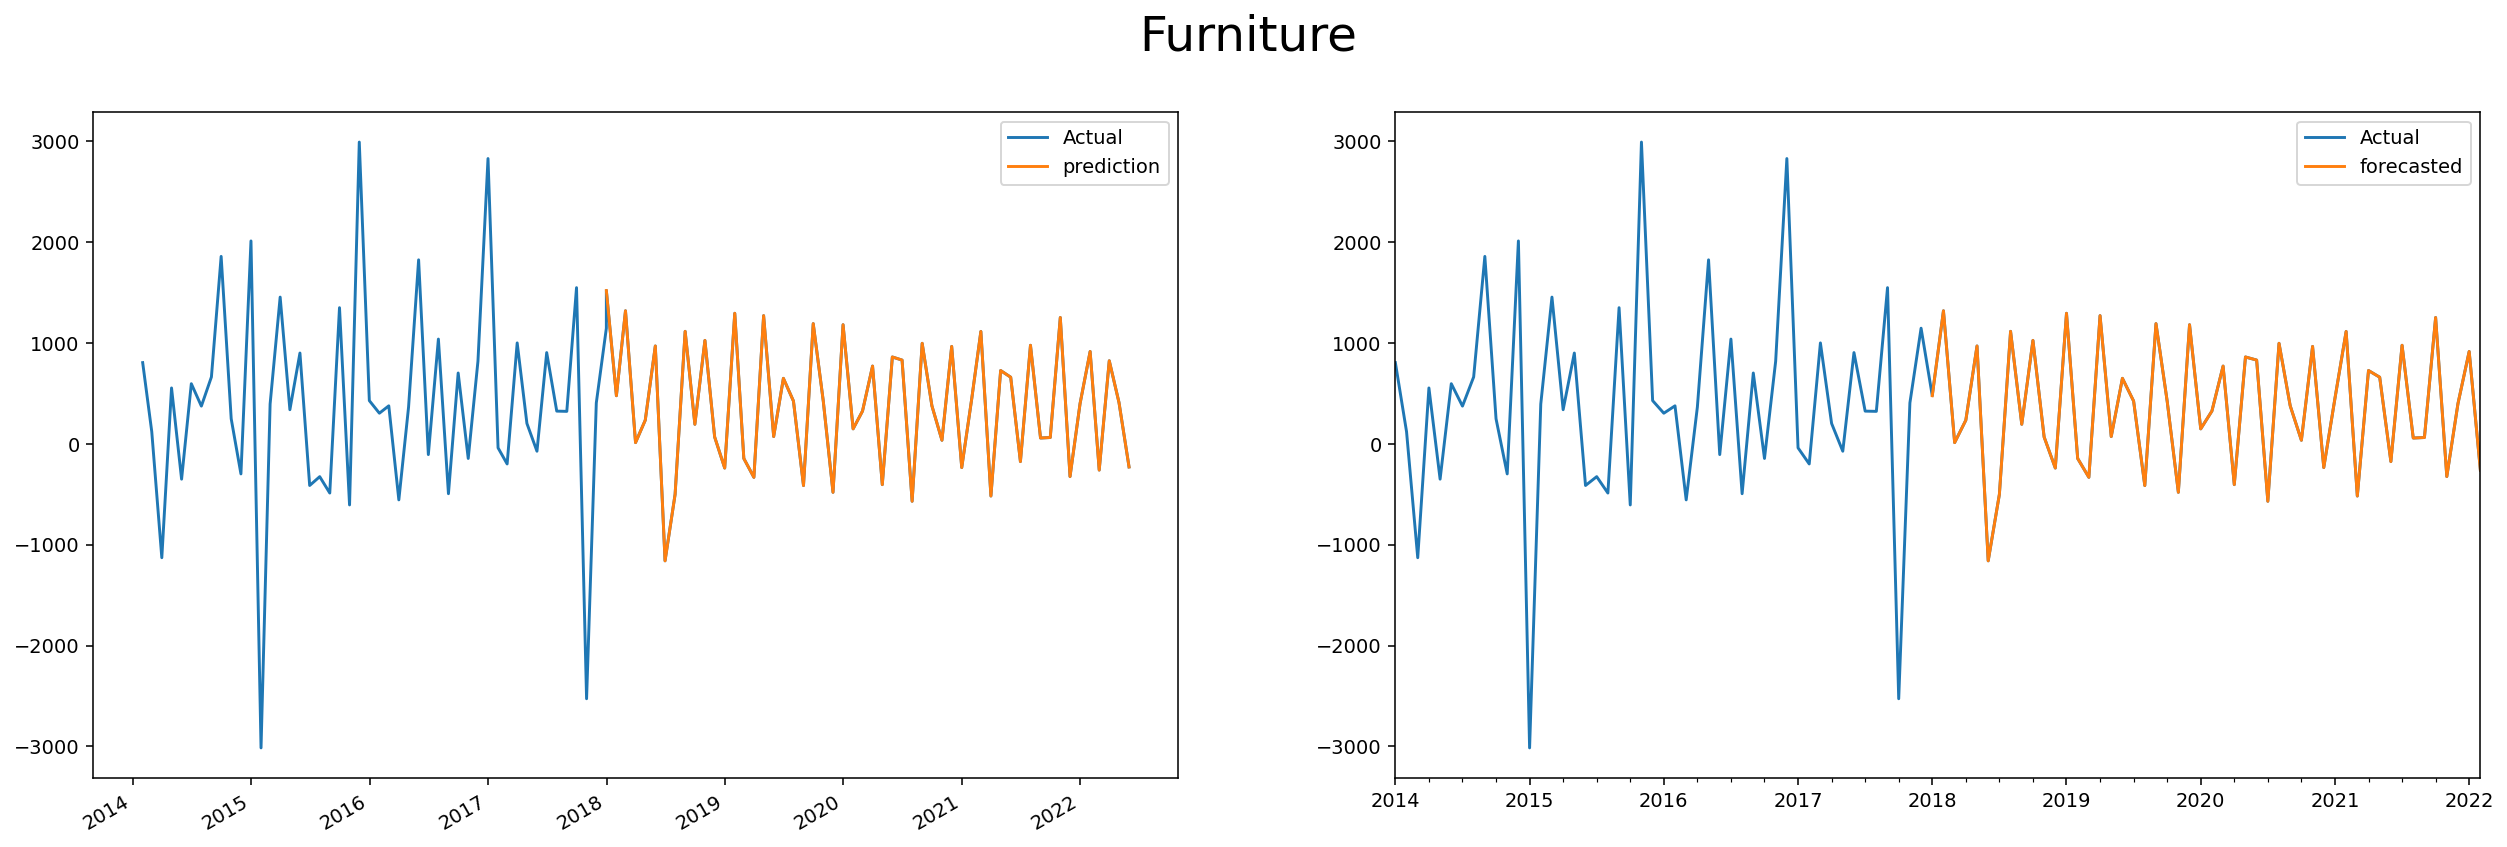

In [28]:
forecasting_profit(furn,8,9)

### EDA Furniture

In [29]:
import pandas as pd
from pandas_profiling import ProfileReport

#EDA using pandas-profiling
profile = ProfileReport(df[df.Category=='Furniture'], explorative=True)

#Saving results to a HTML file
profile.to_file("furniture.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### ARMA Technology

1036.2536989760986


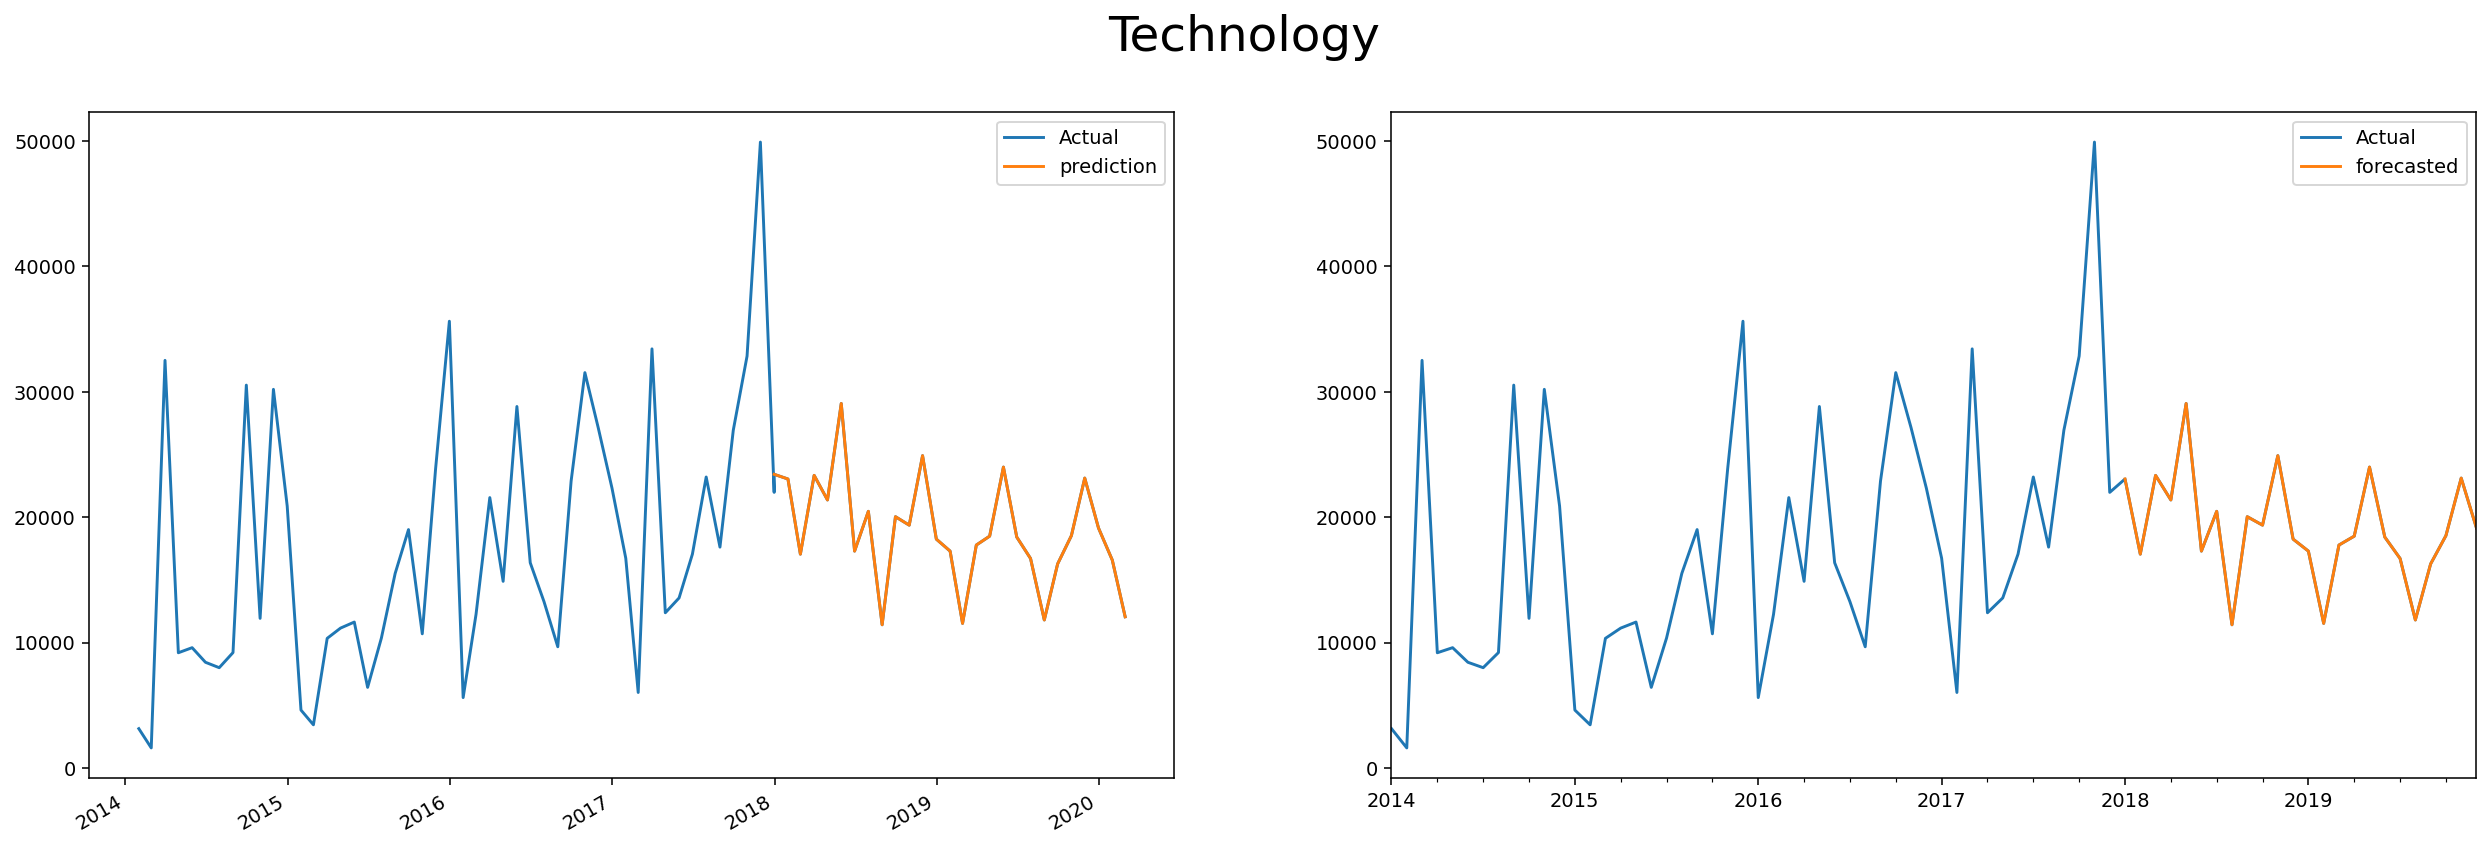

In [30]:
forecasting(tech,6,0,6)

905.6550535854351


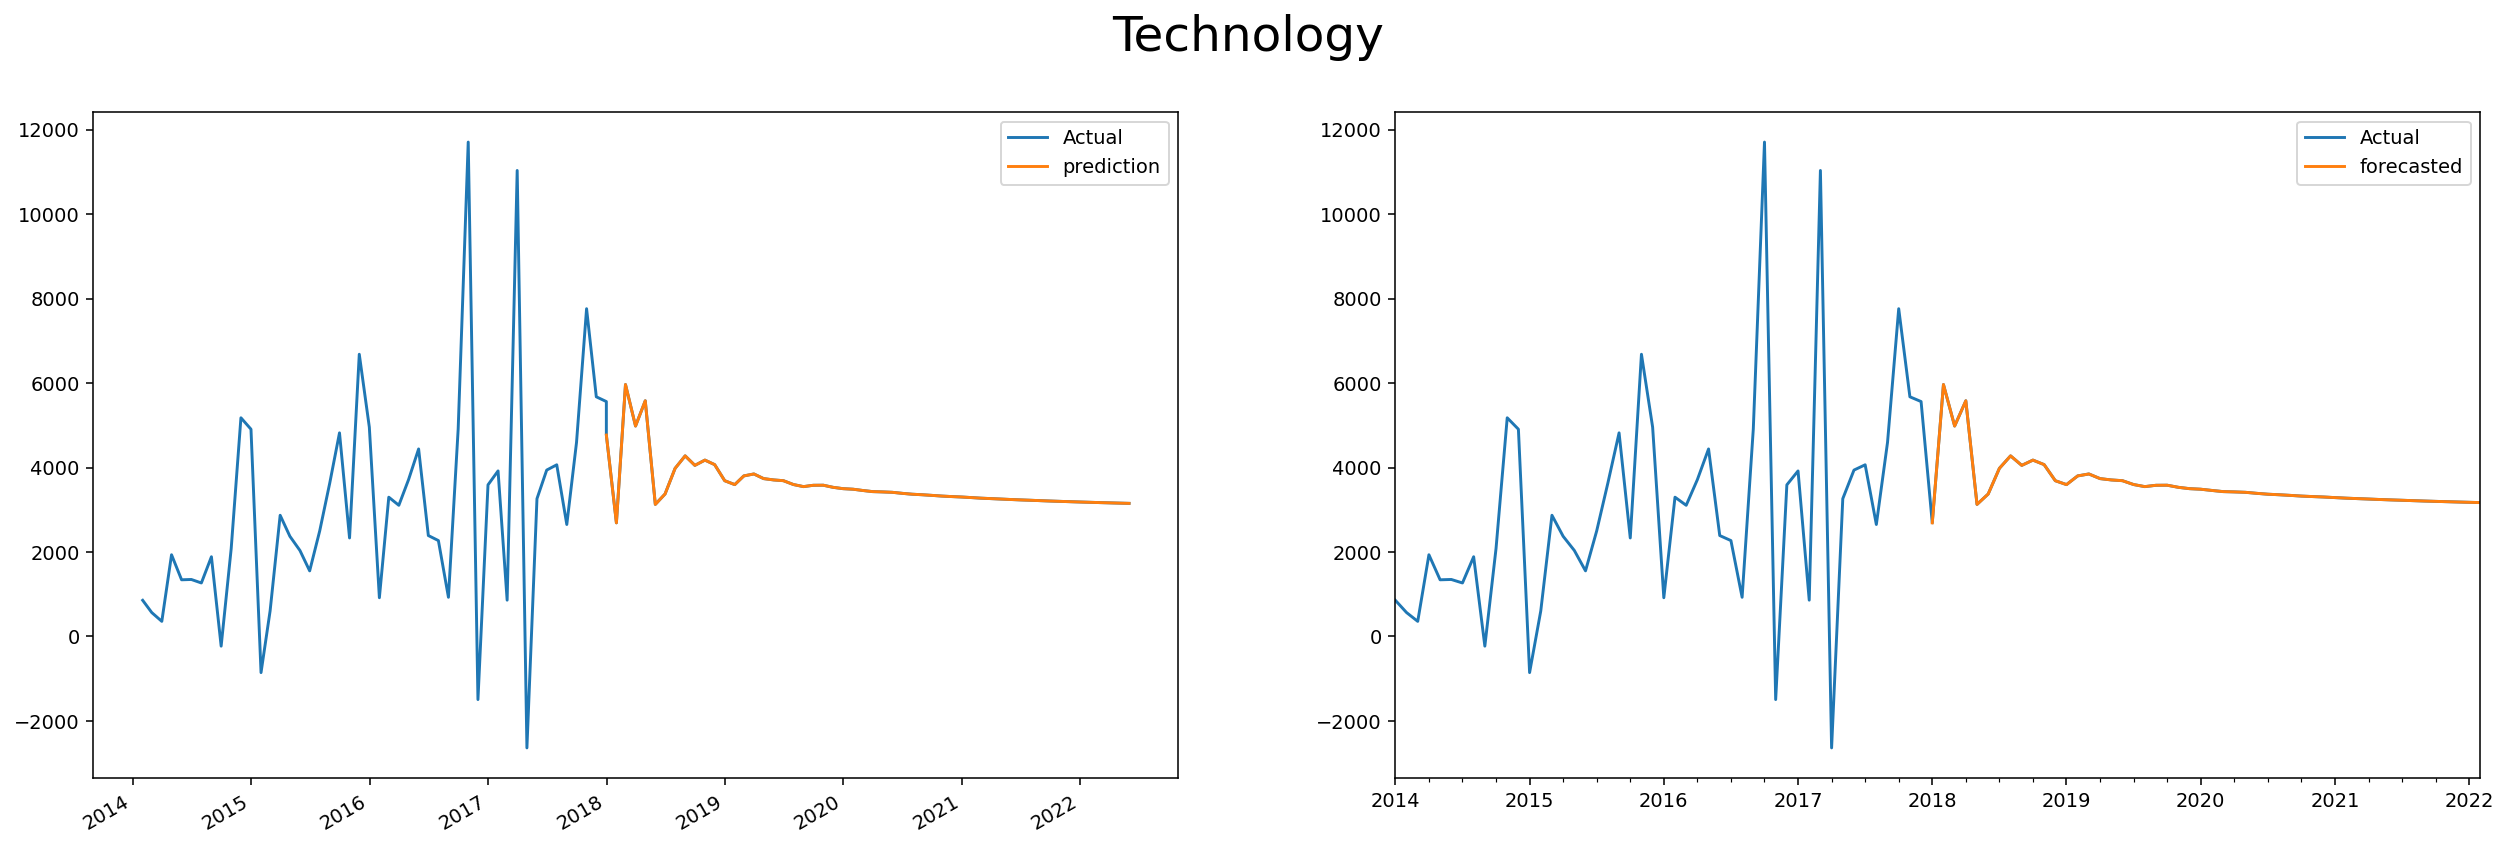

In [31]:
forecasting_profit(tech,7,6)

### EDA Technology

In [32]:
import pandas as pd
from pandas_profiling import ProfileReport

#EDA using pandas-profiling
profile = ProfileReport(df[df.Category=='Technology'], explorative=True)

#Saving results to a HTML file
profile.to_file("Technology.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### ACF and PACF in Office supply

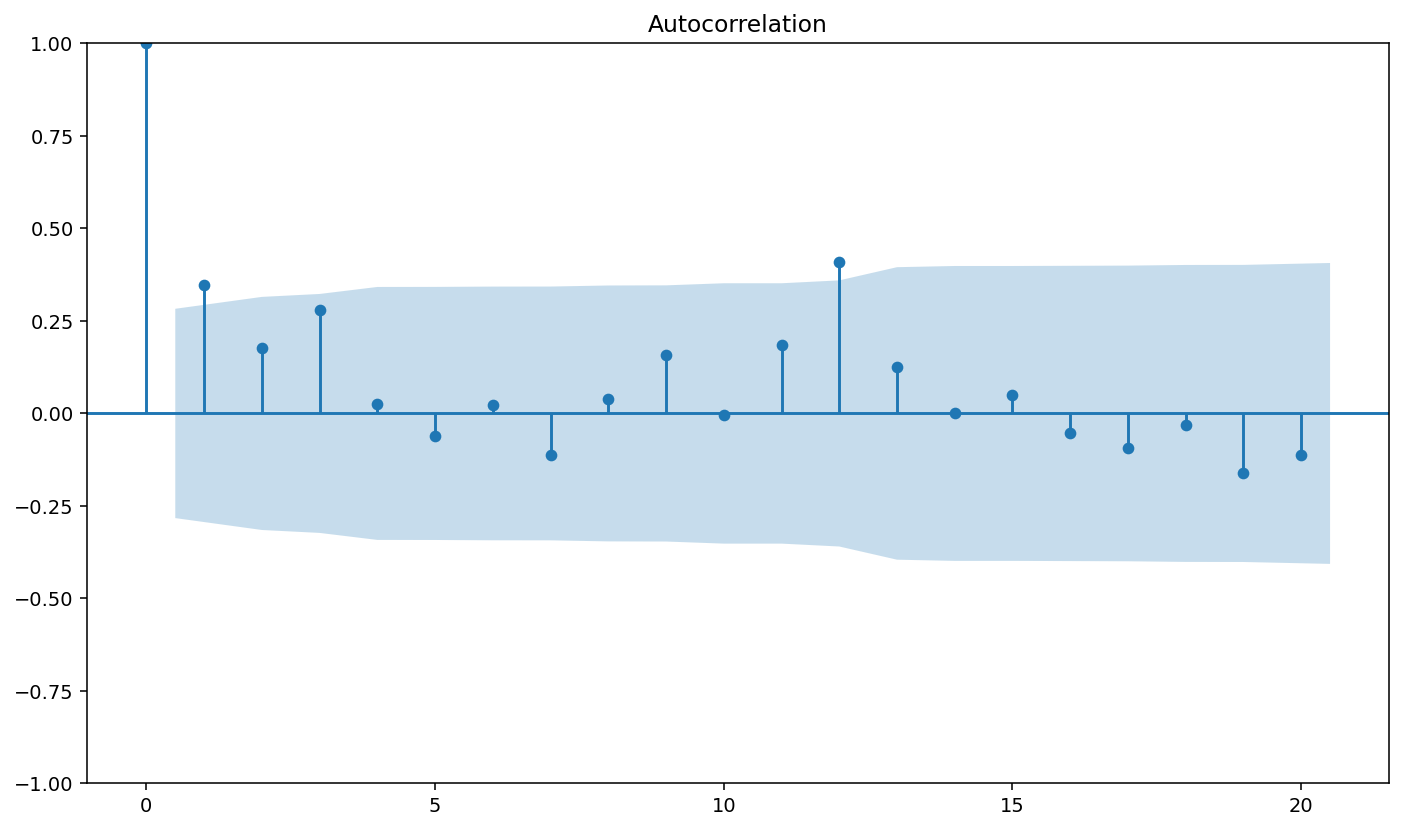

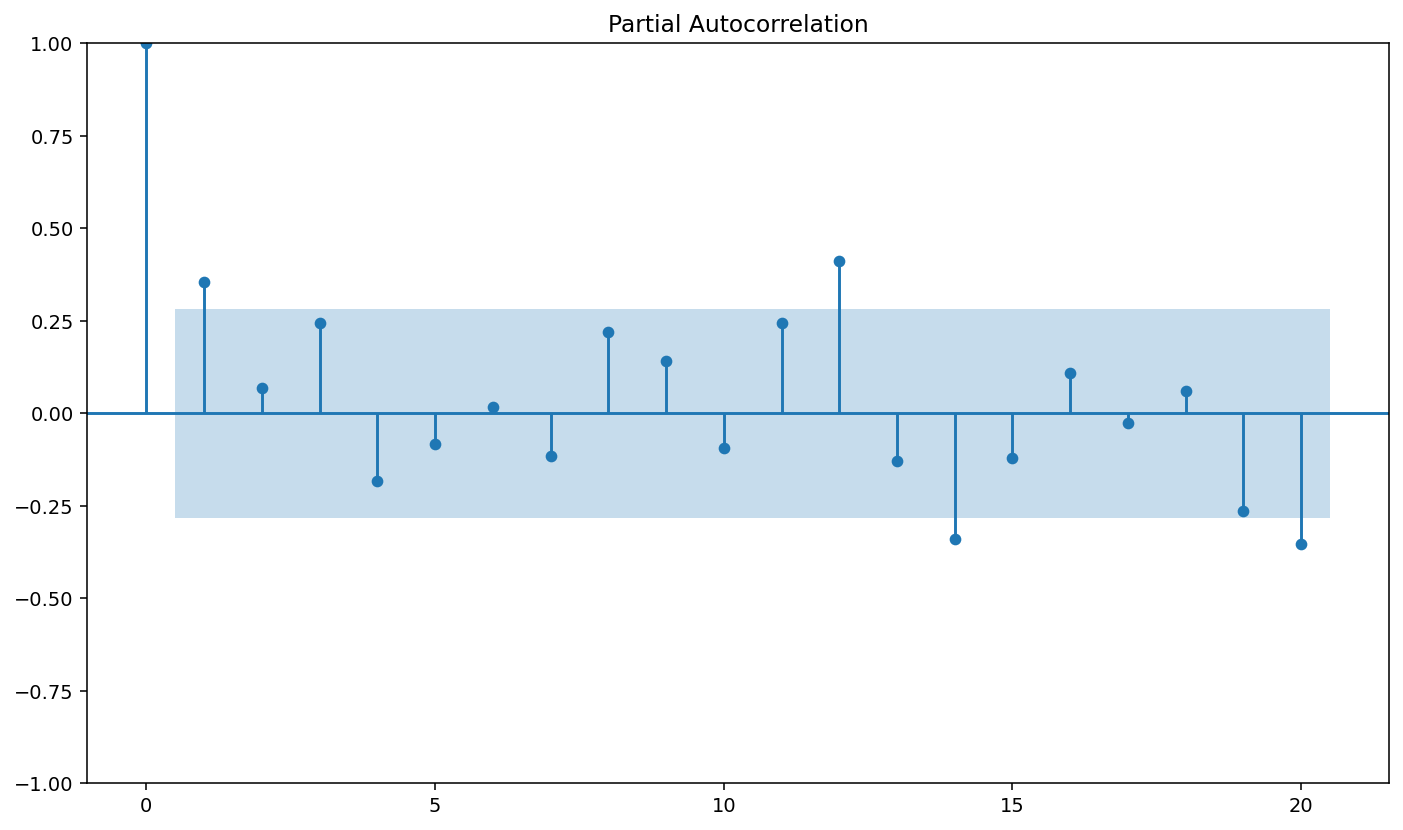

In [33]:
plot_acf(os.resample('M').sum().Sales,lags=20);
plot_pacf(os.resample('M').sum().Sales,lags=20);

In [34]:
for i in range(1,9):
  ar_model = ARIMA(os.resample('M').sum().Sales,order=(i,1,0))
  ar_fit = ar_model.fit()
  print(f'When p is taken as = {i}, value of AIC is {ar_fit.aic}')
print(ar_fit.summary())

When p is taken as = 1, value of AIC is 988.1507102328728
When p is taken as = 2, value of AIC is 981.5067421675725
When p is taken as = 3, value of AIC is 983.5208979125147
When p is taken as = 4, value of AIC is 985.2158821963486
When p is taken as = 5, value of AIC is 986.7844733805478
When p is taken as = 6, value of AIC is 988.728773765833
When p is taken as = 7, value of AIC is 988.4196449064497
When p is taken as = 8, value of AIC is 989.4405152764101
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(8, 1, 0)   Log Likelihood                -485.720
Date:                Wed, 01 Feb 2023   AIC                            989.441
Time:                        16:34:29   BIC                           1006.092
Sample:                    01-31-2014   HQIC                           995.707
                         - 12-31-2017                          

In [35]:
for i in range(1,9):
  ar_model = ARIMA(os.resample('M').sum().Sales,order=(0,1,i))
  ar_fit = ar_model.fit()
  print(f'When q is taken as = {i}, value of AIC is {ar_fit.aic}')
print(ar_fit.summary())

When q is taken as = 1, value of AIC is 981.3626222403499
When q is taken as = 2, value of AIC is 982.9313519832433
When q is taken as = 3, value of AIC is 984.5808858538348
When q is taken as = 4, value of AIC is 984.0853404738513
When q is taken as = 5, value of AIC is 988.5564495801992
When q is taken as = 6, value of AIC is 987.20660022137
When q is taken as = 7, value of AIC is 989.4438247290037
When q is taken as = 8, value of AIC is 990.038468146321
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(0, 1, 8)   Log Likelihood                -486.019
Date:                Wed, 01 Feb 2023   AIC                            990.038
Time:                        16:34:30   BIC                           1006.690
Sample:                    01-31-2014   HQIC                           996.304
                         - 12-31-2017                            

### ARIMA Office Supplies

984.6828919436438


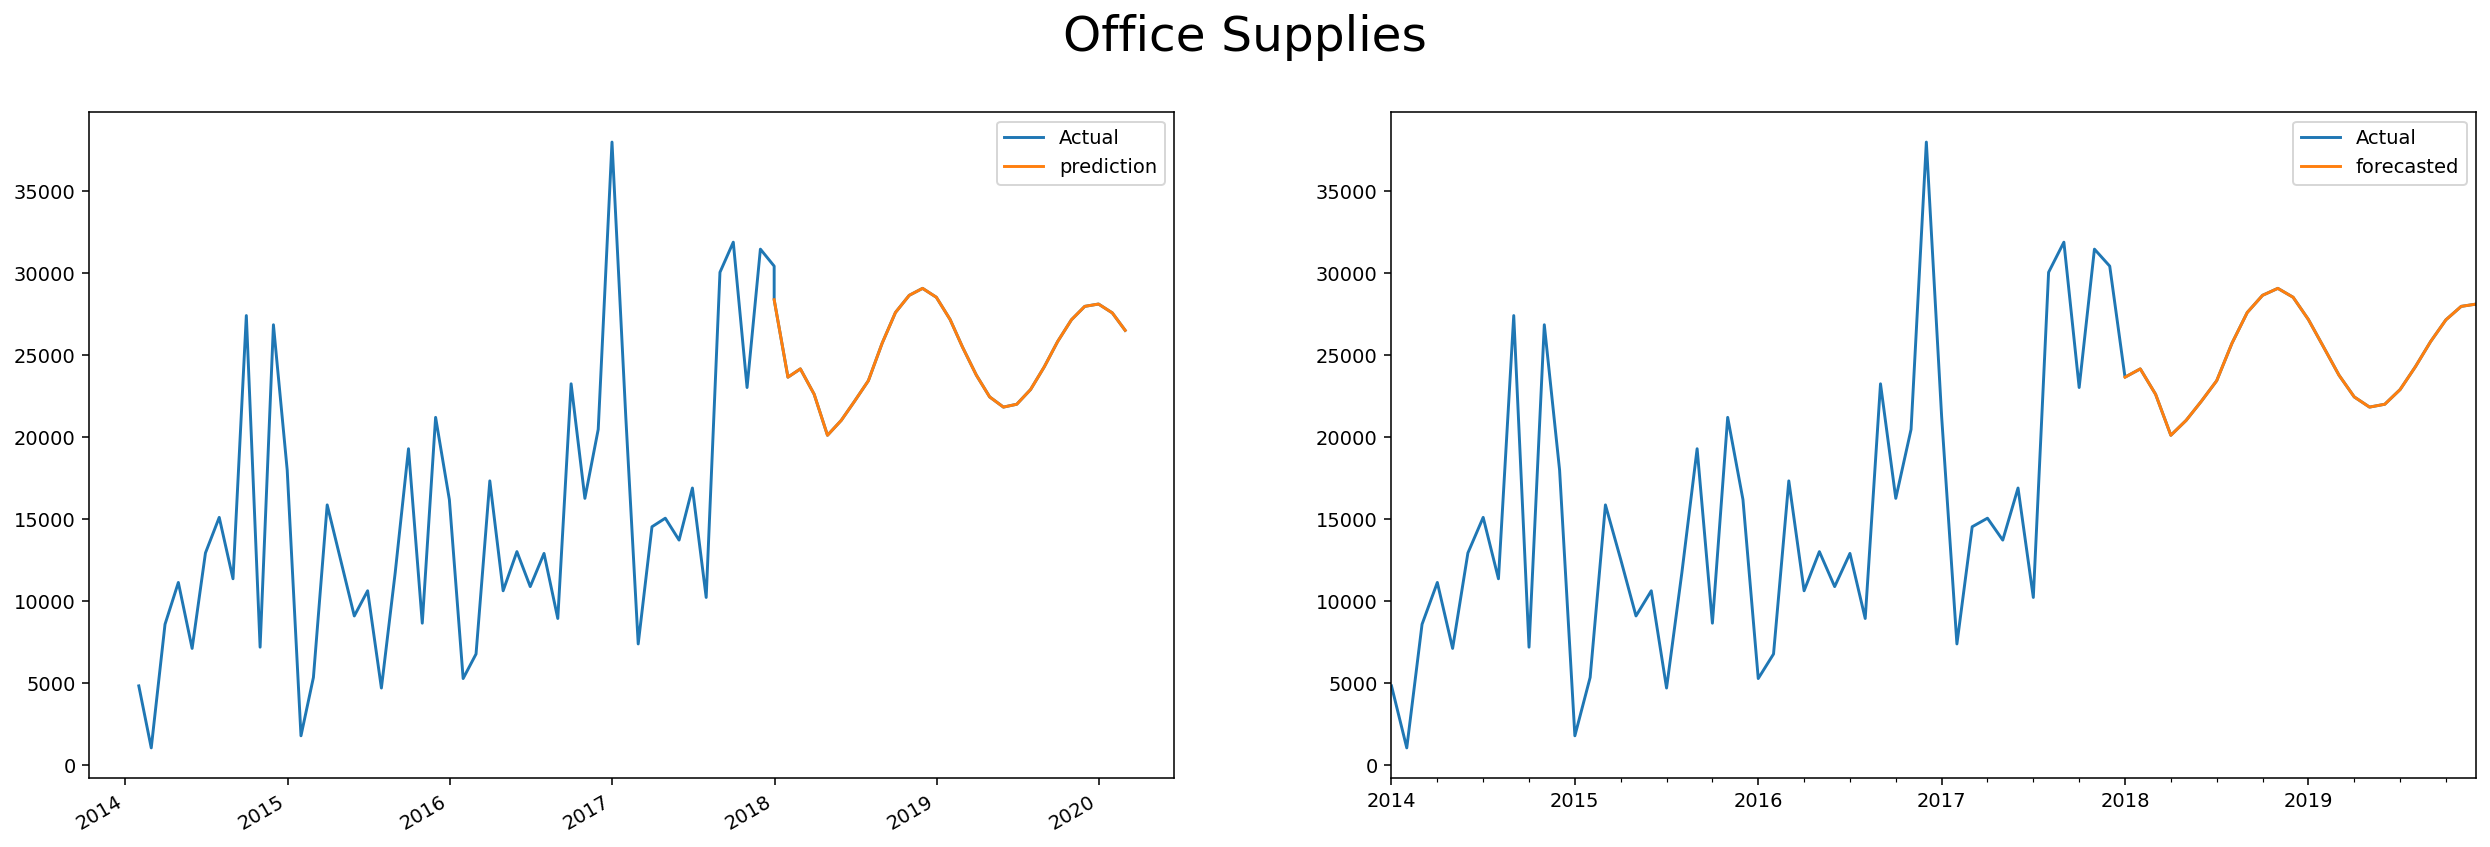

In [36]:
forecasting(os,4,1,2)

In [37]:
aar_model = auto_arima(os.resample('M').sum().Sales,start_p=0,max_p=9,start_q=0,max_q=9,seasonal=True,m=12,trace=True,d=1,D=1)
print(aar_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=731.838, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=740.437, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=726.023, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=717.172, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=728.668, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=718.898, Time=0.15 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=718.892, Time=0.99 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=718.780, Time=0.24 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=725.260, Time=0.53 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=730.324, Time=0.03 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=722.788, Time=0.09 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=718.277, Time=0.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=722.473, Time=0.13 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=723.414, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12] intercep

In [38]:
p=0;q=1;d=1
P=0;Q=1;D=1
sarima_sales = sm.tsa.statespace.SARIMAX(os.resample('M').sum().Sales,order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
sarima_sales.aic

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55049D+00    |proj g|=  3.37786D-01

At iterate    5    f=  7.45579D+00    |proj g|=  1.17579D-03

At iterate   10    f=  7.45579D+00    |proj g|=  1.25073D-04

At iterate   15    f=  7.45576D+00    |proj g|=  2.23895D-03

At iterate   20    f=  7.45189D+00    |proj g|=  3.10660D-02

At iterate   25    f=  7.40826D+00    |proj g|=  5.20867D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     30      1     0     0   

 This problem is unconstrained.


717.1721431050508

### SARIMA Office Supplies

Text(0.5, 0.98, 'Office Supplies')

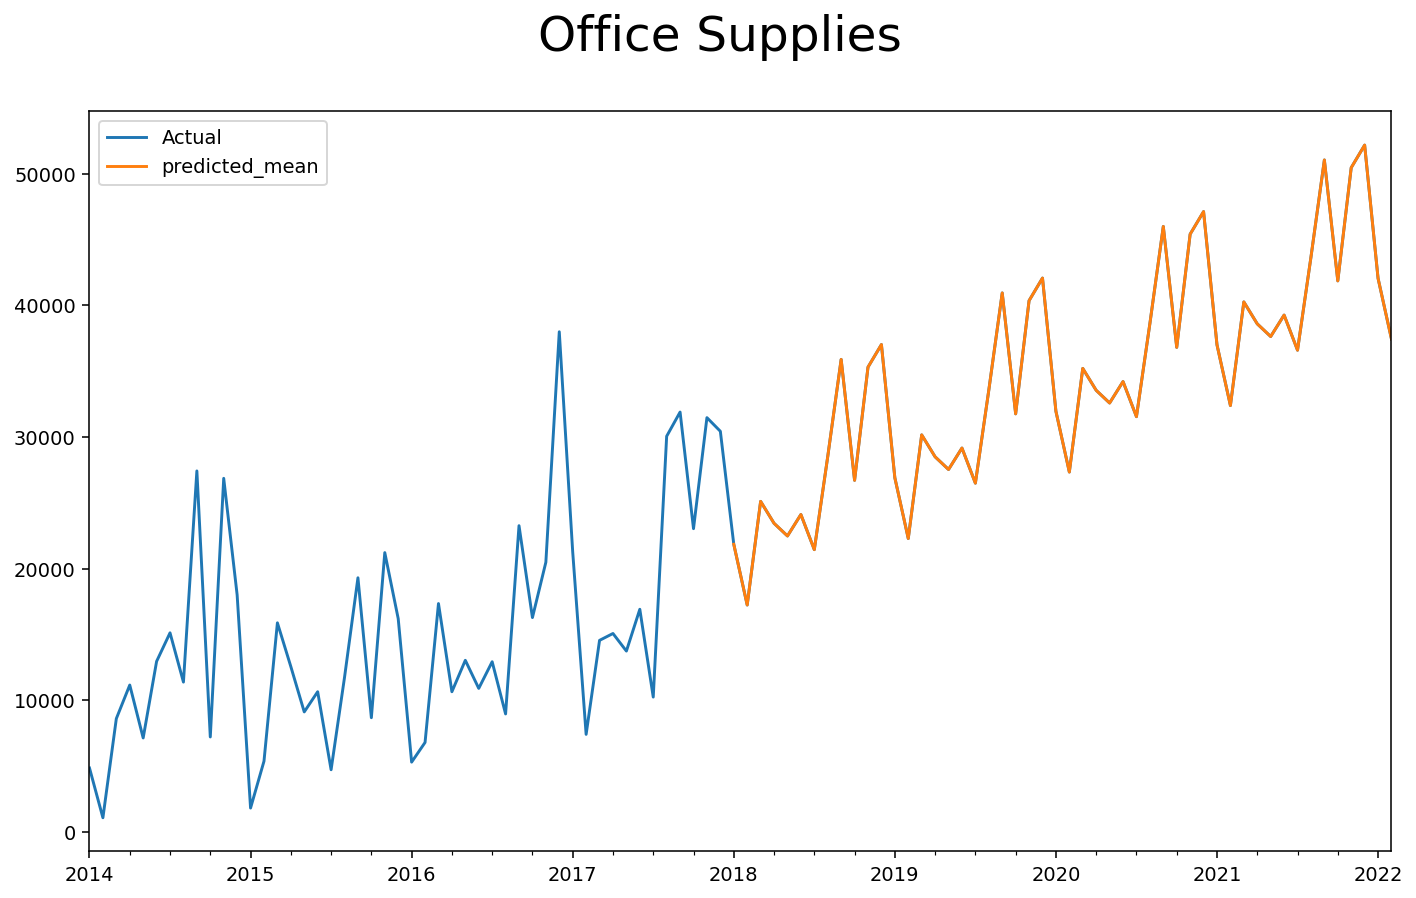

In [39]:
pd.concat([os.resample('M').sum().Sales,sarima_sales.forecast(50)],axis=0).plot(label='Actual')
sarima_sales.forecast(50).plot()
plt.legend()
plt.suptitle(os.Category[0],size=25)

In [40]:
print(auto_arima(os.resample('M').sum().Profit,start_p=0,max_p=9,start_q=0,max_q=9,seasonal=True,m=12,trace=True,d=1,D=1).summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=668.086, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=656.118, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=667.469, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=654.025, Time=0.81 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.64 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=656.806, Time=0.56 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=654.309, Time=0.76 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=1.62 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=655.914, Time=0.68 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]          
Total fit tim

In [41]:
p=1;q=0;d=1
P=2;Q=0;D=1
sarima_profit = sm.tsa.statespace.SARIMAX(os.resample('M').sum().Profit,order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
sarima_profit.aic

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78603D+00    |proj g|=  4.65106D-02

At iterate    5    f=  6.77810D+00    |proj g|=  1.29546D-04


 This problem is unconstrained.



At iterate   10    f=  6.77809D+00    |proj g|=  1.64786D-03

At iterate   15    f=  6.77637D+00    |proj g|=  2.57422D-02

At iterate   20    f=  6.73248D+00    |proj g|=  2.57834D-02

At iterate   25    f=  6.72943D+00    |proj g|=  1.65105D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   2.392D-06   6.729D+00
  F =   6.7294252207427379     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


654.0248211913029

Text(0.5, 0.98, 'Office Supplies')

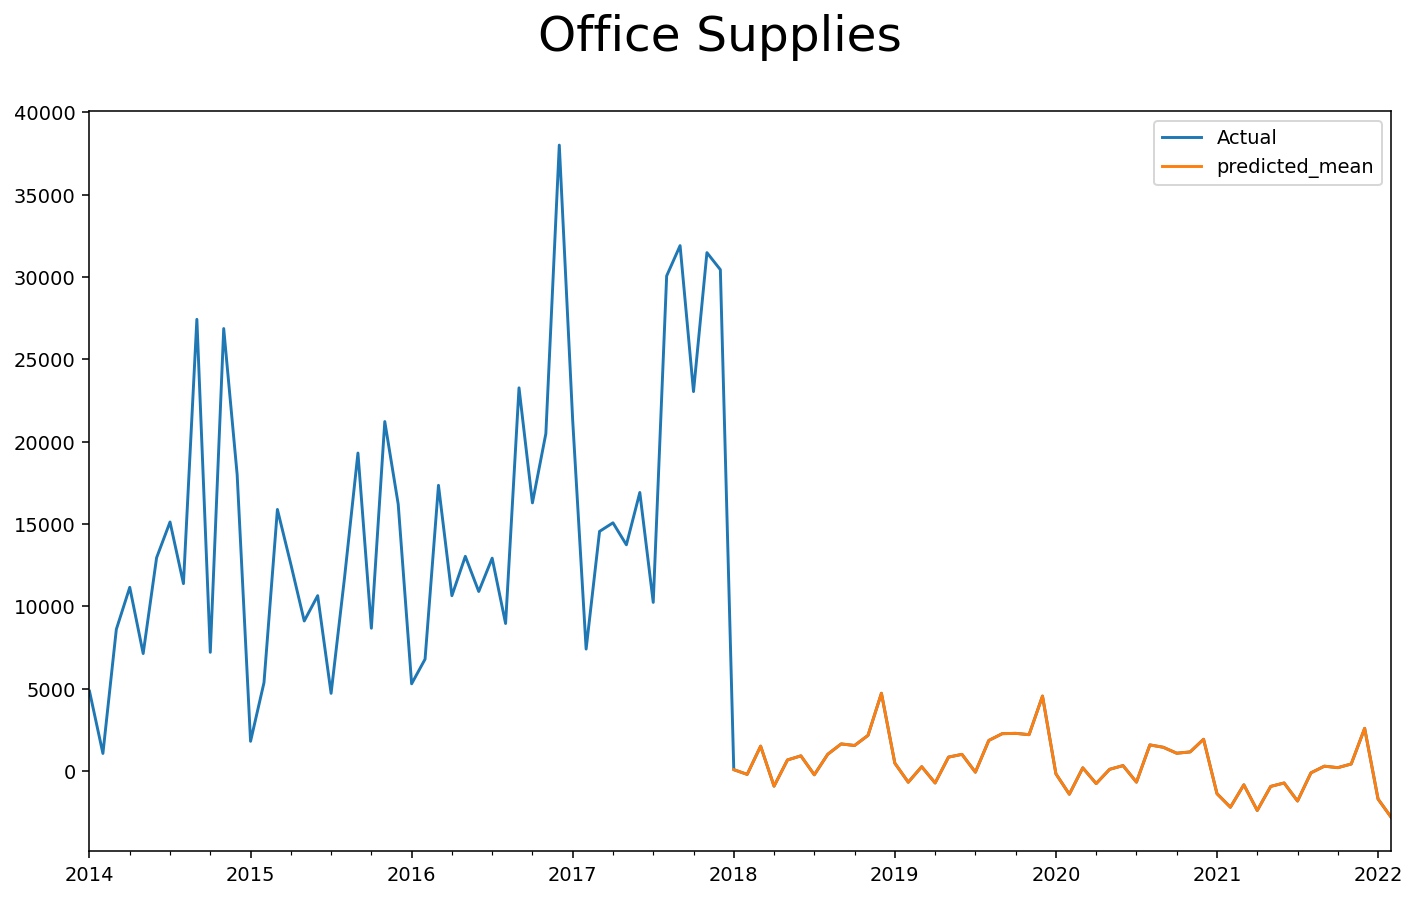

In [42]:
pd.concat([os.resample('M').sum().Sales,sarima_profit.forecast(50)],axis=0).plot(label='Actual')
sarima_profit.forecast(50).plot()
plt.legend()
plt.suptitle(os.Category[0],size=25)

In [43]:
import pandas as pd
from pandas_profiling import ProfileReport

#EDA using pandas-profiling
profile = ProfileReport(df[df.Category=='Office Supplies'], explorative=True)

#Saving results to a HTML file
profile.to_file("office.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
def optimize_ARIMA(order_list,d, data):
   
    results = []
    MSE=[]
    RMSE=[]
    
    for order in tqdm_notebook(order_list):
        try: 
            model = ARIMA(data, order=(order[0],d,order[1])).fit()
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        predictions = model.predict(0,len(data)-1)

        actual = [] ; pred = []

        for i in range(len(predictions)):
            actual.append(data[i])
            pred.append(predictions[i])

        df_res = pd.DataFrame({'Actual' : actual , 'Predictions' : pred})
        #df_res['Error'] = df_res['Actual'] - df_res['Predictions']

        mse = mean_squared_error(df_res['Actual'] , df_res['Predictions'])
        MSE.append(mse)

        RMSE.append(np.sqrt(mse))
        
    result_df = pd.concat([pd.DataFrame(results),pd.DataFrame(MSE),pd.DataFrame(RMSE)],axis=1)
    result_df.columns = ['(p, q)', 'AIC','MSE','RMSE']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True)
    return result_df

In [49]:
ps = range(0, 8, 1)
d = 0
qs = range(0, 8, 1)
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
   
result_df = optimize_ARIMA(parameters_list,d,tech.resample('M').sum().Sales)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, q)",AIC,MSE,RMSE
0,"(6, 6)",1036.253699,7.500616e+07,8660.609666
1,"(7, 6)",1037.952931,7.511679e+07,8666.994324
2,"(6, 4)",1029.681215,7.538905e+07,8682.686734
3,"(4, 7)",1033.899430,7.552588e+07,8690.562478
4,"(5, 6)",1034.617233,7.597238e+07,8716.213841
...,...,...,...,...
59,"(2, 0)",1029.239522,1.017773e+08,10088.473963
60,"(1, 0)",1027.242584,1.018241e+08,10090.792448
61,"(0, 2)",1029.343021,1.019195e+08,10095.520547
62,"(0, 1)",1027.589197,1.020557e+08,10102.262965


In [46]:
MSE=[]
model = SARIMAX(furn.resample('M').sum().Sales, order=(8,0,9)).fit(disp=-1)
predictions = model.predict(0,len(tech.resample('M').sum().Sales)-1)
actual = [] ; pred = []

for i in range(len(predictions)):
    actual.append(tech.resample('M').sum().Sales[i])
    pred.append(predictions[i])

df_res = pd.DataFrame({'Actual' : actual , 'Predictions' : pred})
#df_res['Error'] = df_res['Actual'] - df_res['Predictions']

mse = mean_squared_error(df_res['Actual'] , df_res['Predictions'])
print(mse)
print(np.sqrt(mse))

94343156.61568789
9713.04054432431


In [47]:
pd.DataFrame({'(p,d,q)':[(8,0,9),(6,0,6),(1,1,0)],'AIC':[1002.6530,1036.2536,654.0248],'MSE':[94343156.615,80104857.357,115227079.905],'RMSE':[9713.04054432431,8950.131695001452,10734.387]},index=['Furniture','Technology','Office Supply'])

,"(p,d,q)",AIC,MSE,RMSE
Furniture,"(8, 0, 9)",1002.6530,9.434316e+07,9713.040544
Technology,"(6, 0, 6)",1036.2536,8.010486e+07,8950.131695
Office Supply,"(1, 1, 0)",654.0248,1.152271e+08,10734.387000
